In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import datetime as dt

import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches
from pathlib import Path

In [2]:
import sys

sys.path.append("../src")

In [3]:
from core import SITE_NAMES, DC_COLOR_MAPPINGS, FREQ_GROUPS
from cli import get_file_paths

import bout_clustering as bt_clustering
import bout_plotting as bt_plt
import subsampling as ss
import data_handling as dh
import plotting
import pipeline

# Observation: The activity index is extremely reliant on the arbitrarily chosen time block

## Reasons include:
#### 1) Saturation: The maximum possible activity index for any interval is the total # of time blocks that fit in that interval. For a 30-min interval and a time block of 5-secs, the maximum activity index is 360.
#### 2) Quantization: The set of possible indices are always [0, 1, 2, ..., max.]. This offers us poor resolution when comparing activities as we are only allowed to view differences of 1.

### Both of these reasons combined mean that when the time block is relatively high (so the maximum value will be relatively low), the quanitization makes it so we have relatively few activity index differences per night.

### For example, if time block is 1-min, and the interval length is 30-min. The maximum activity index for an interval is 30. 

#### With a better metric, this would not be much of a problem if the resolution we had access to was in the 0.01. So indices can be in the set of [0, 0.01, 0.02, ... 30]. This would still provide us 3000 possible indices to assign. However, because the activity index is quantized for 1, we only have 30 possible indices to assign any activity. With this, there is a higher chance that many different activities are misassigned to 1 index.

Carp LF1


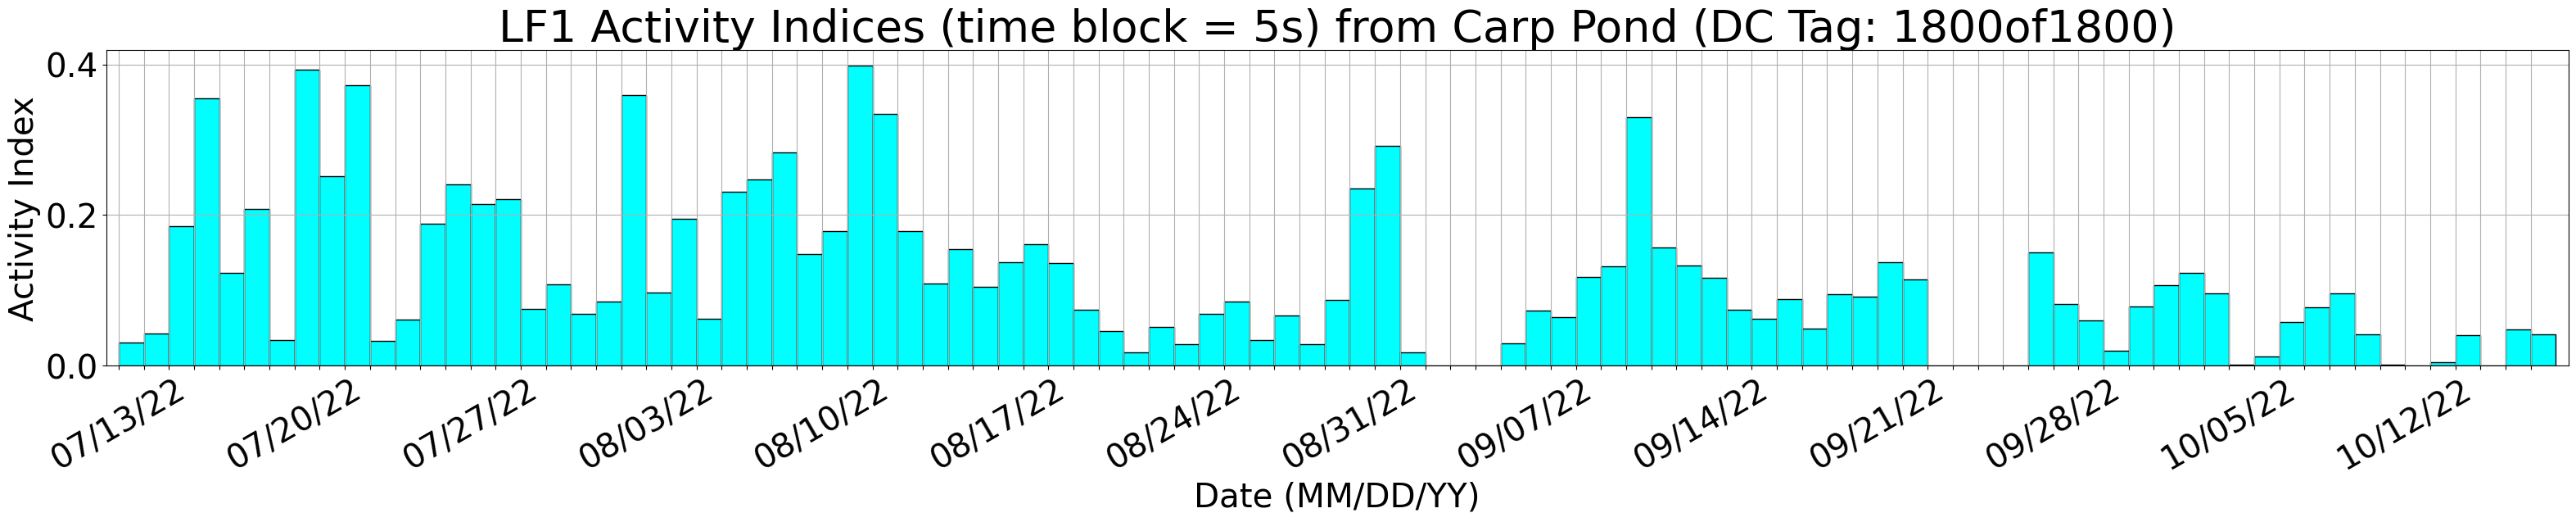

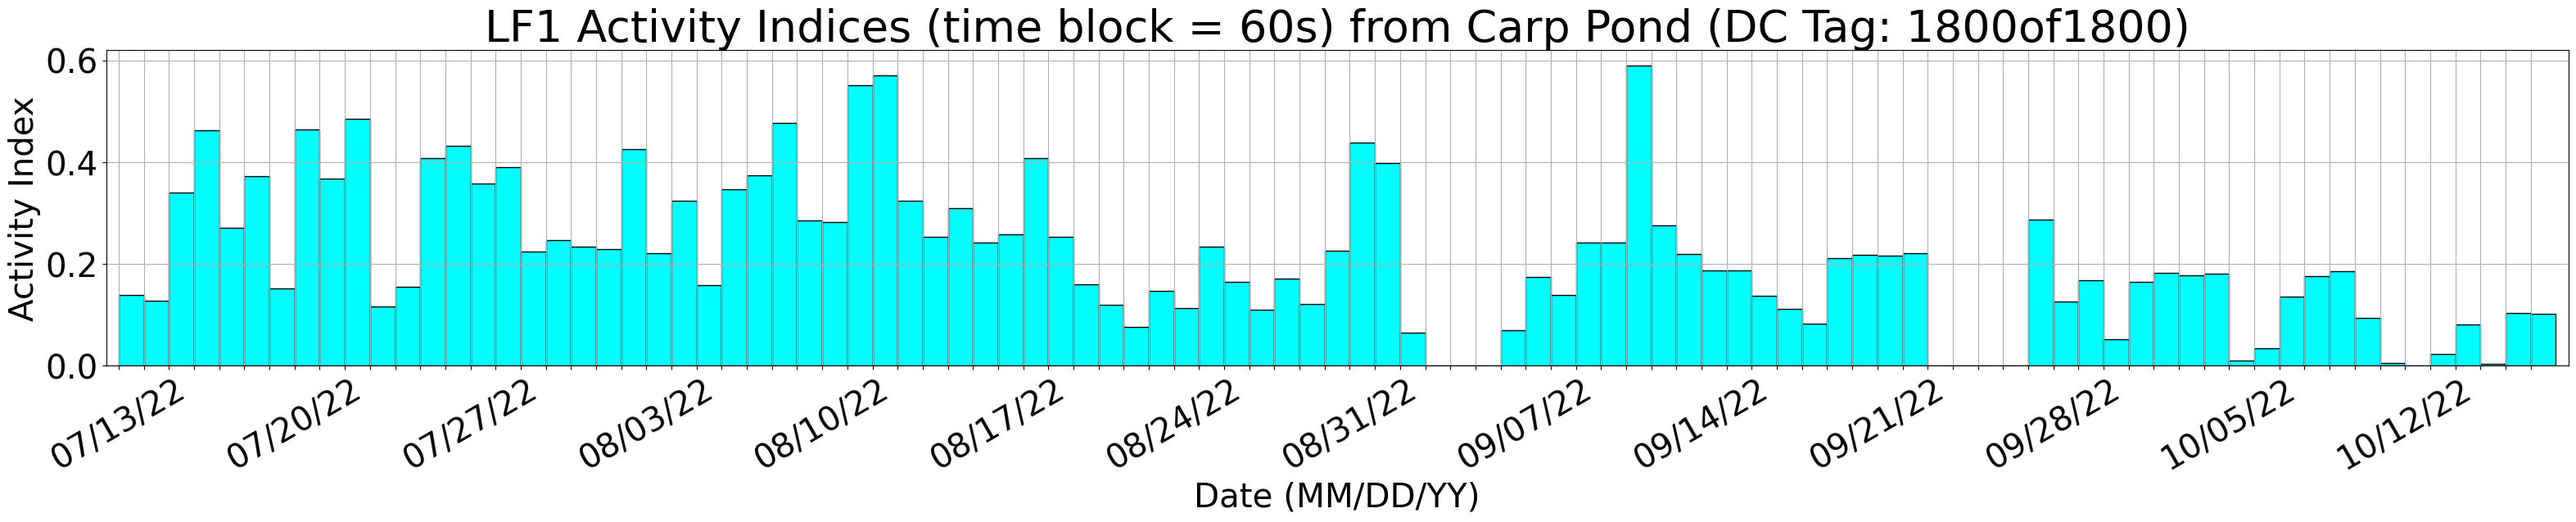

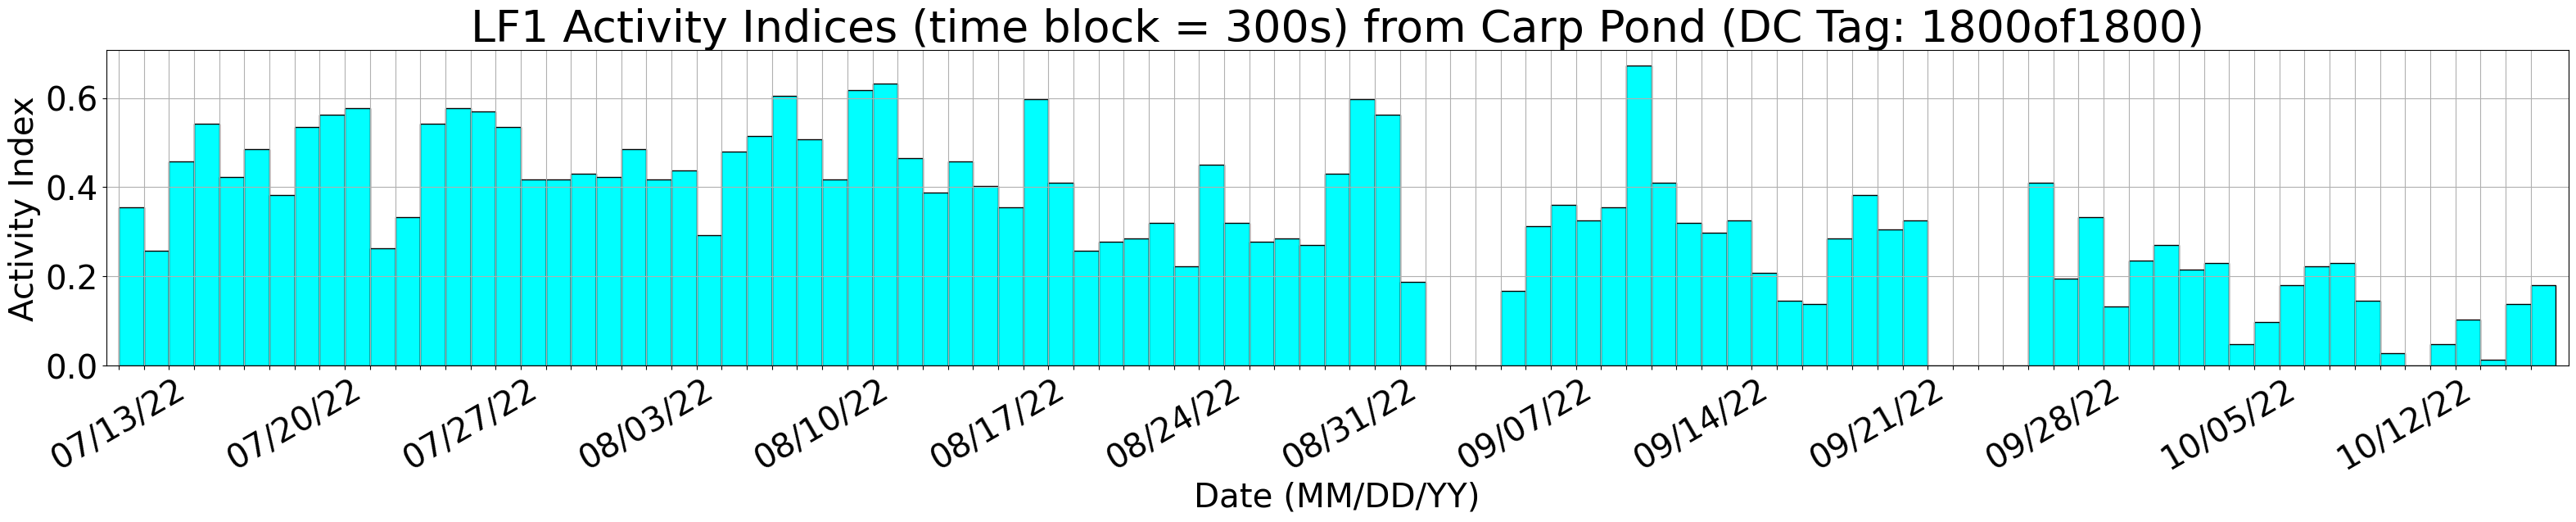

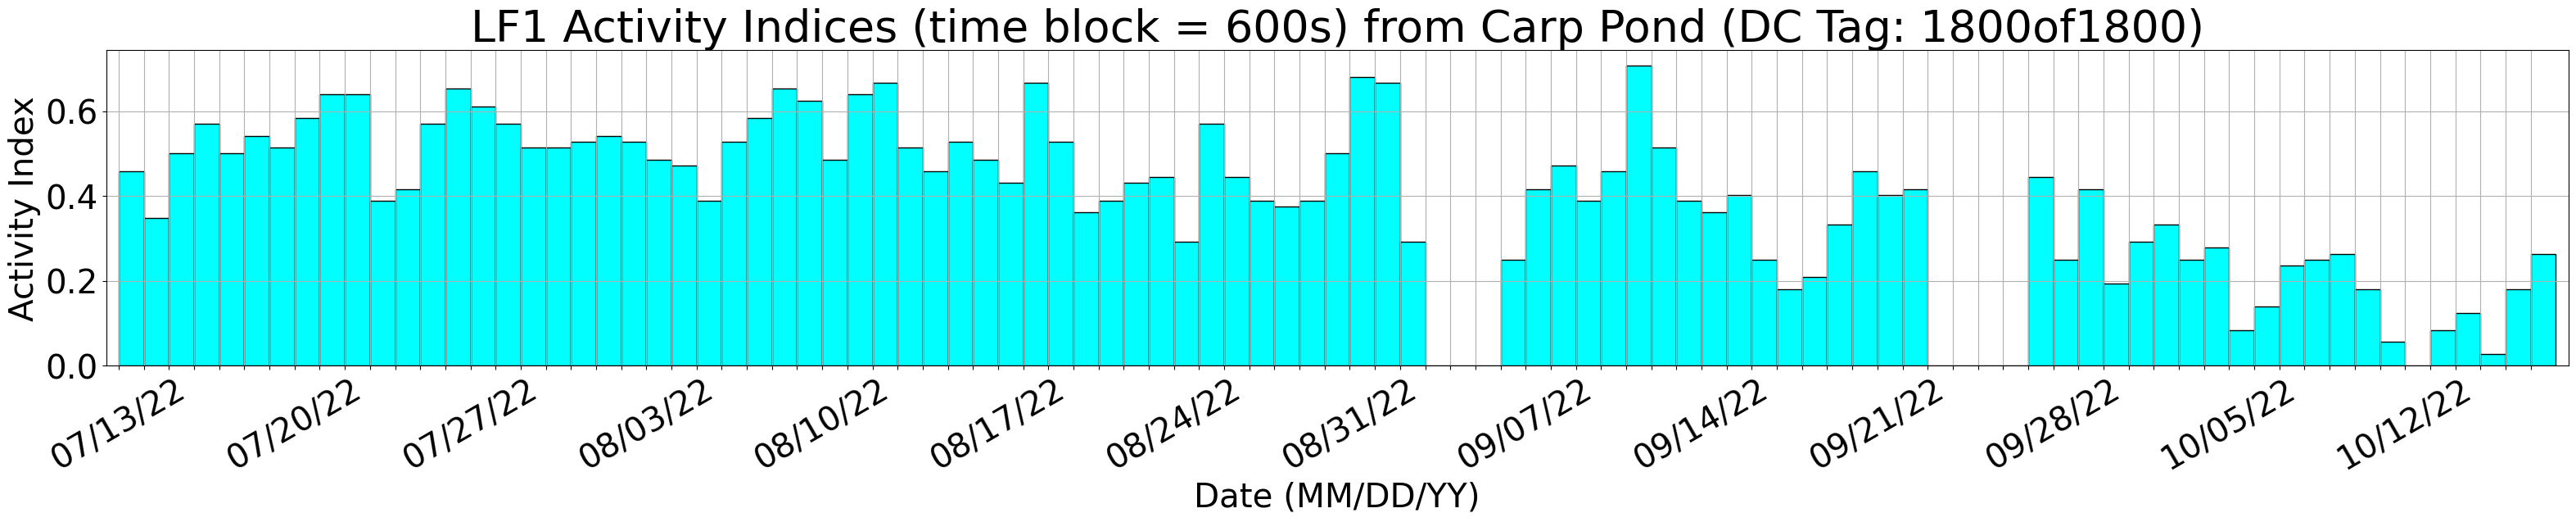

Carp HF1


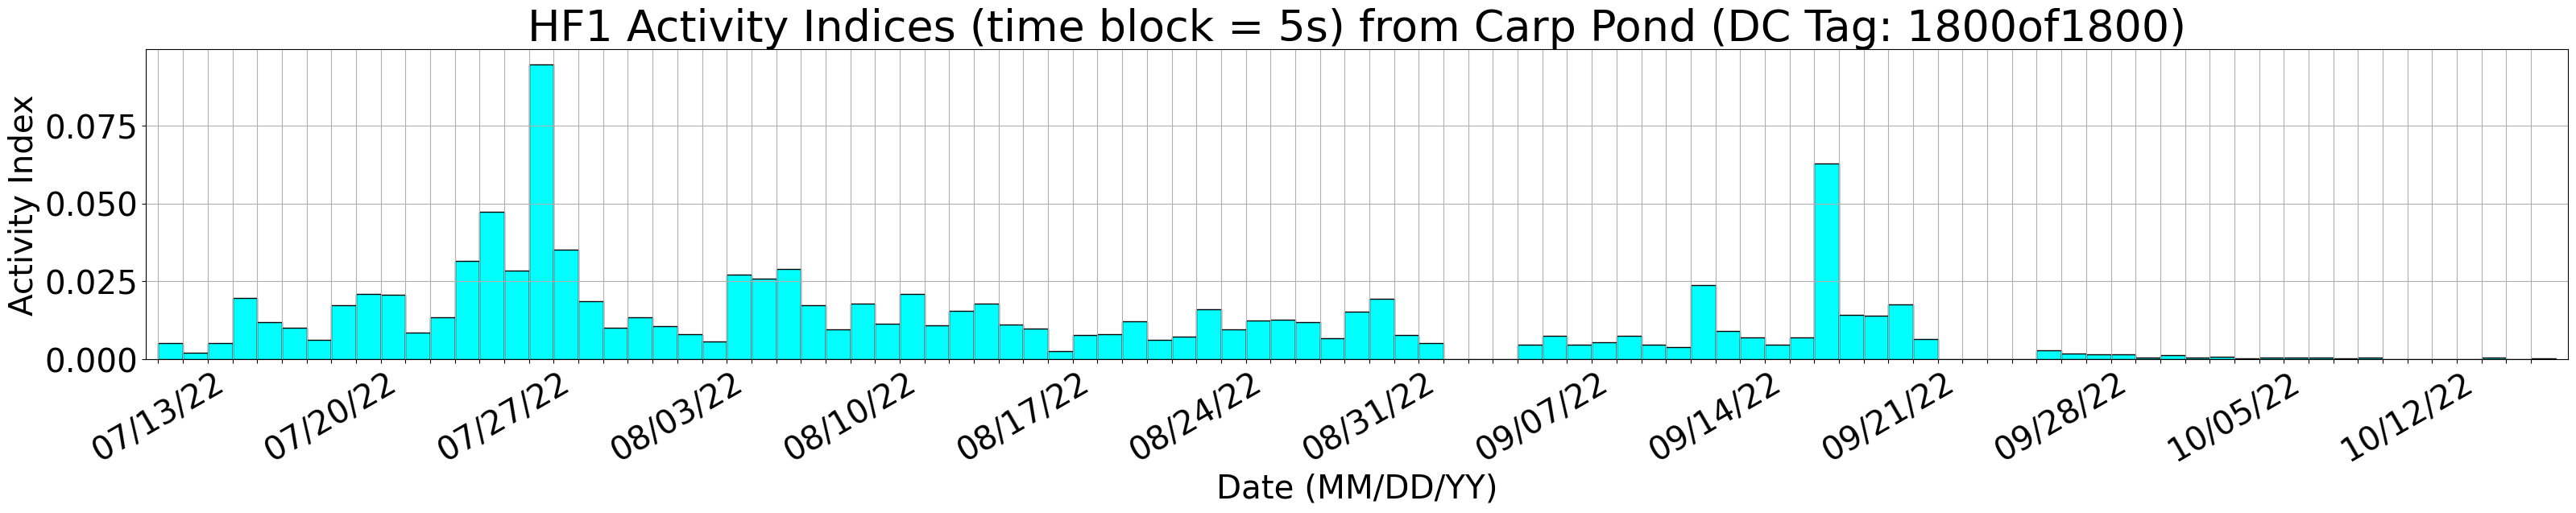

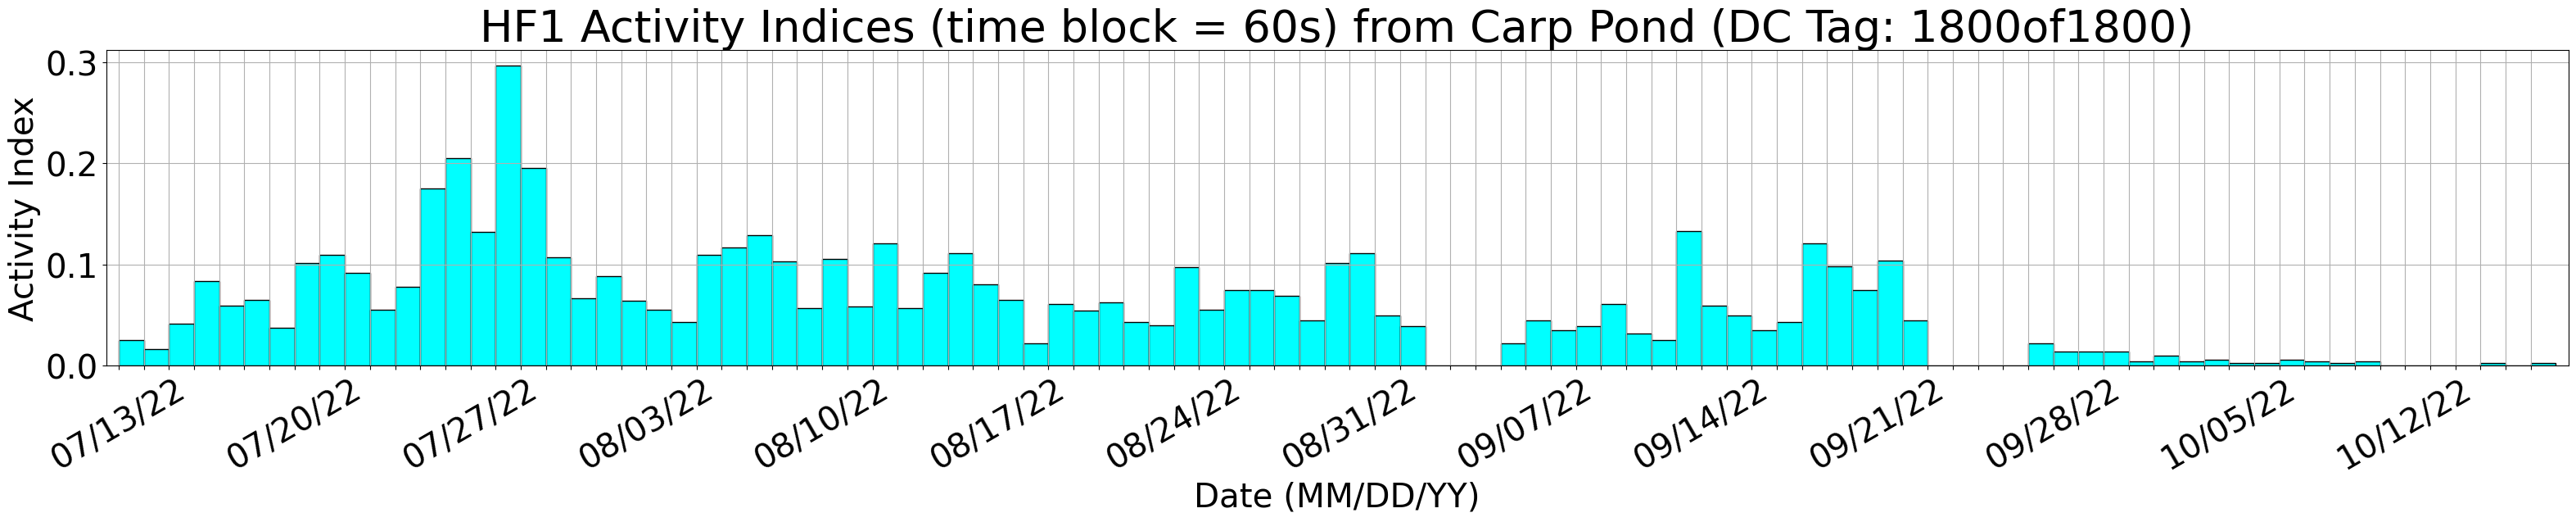

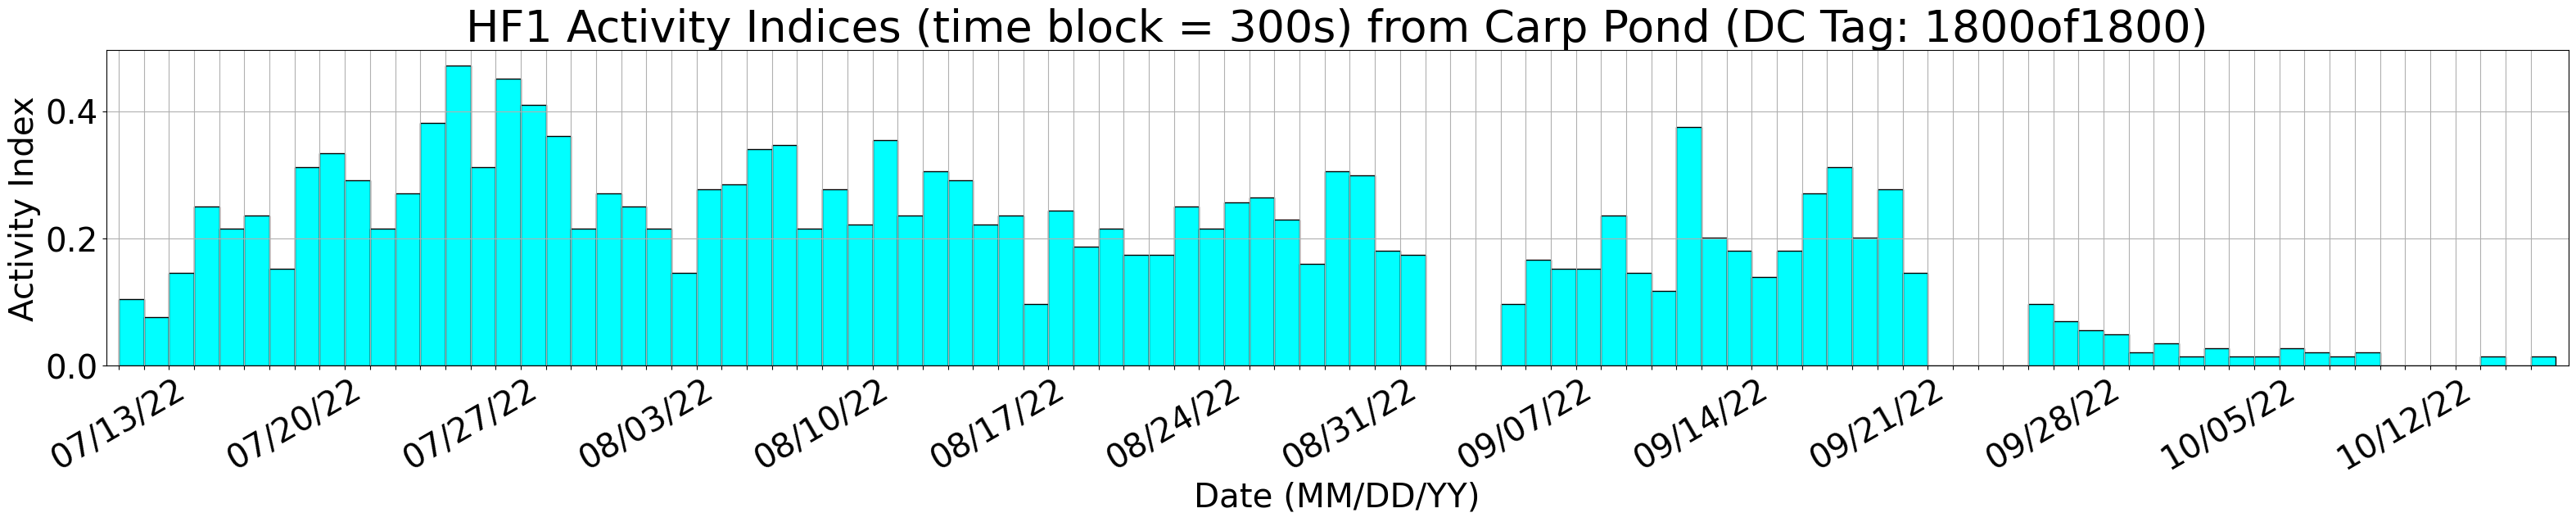

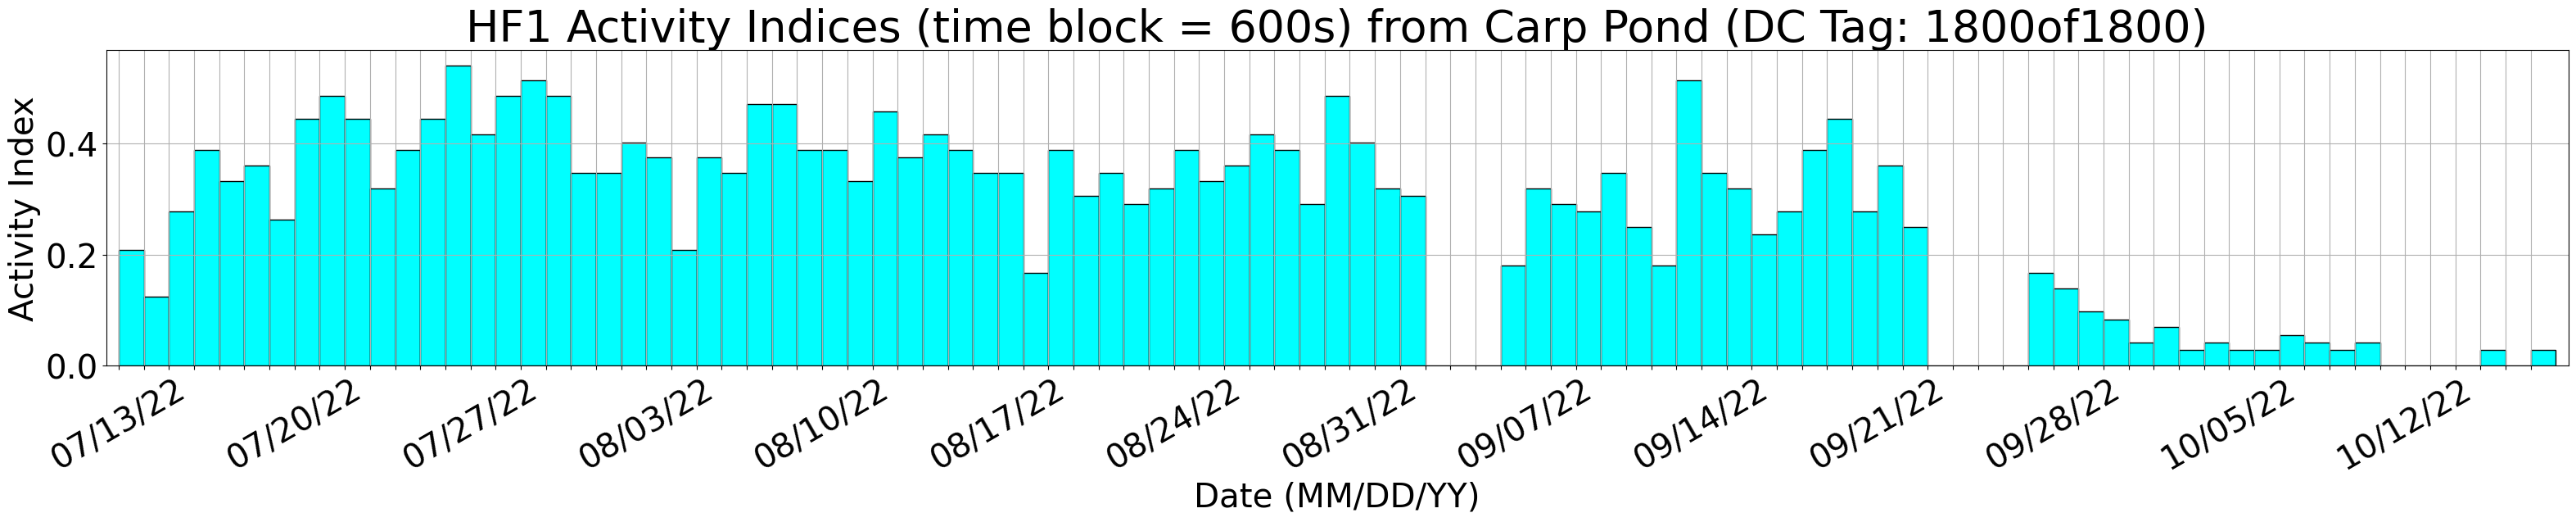

Carp HF2


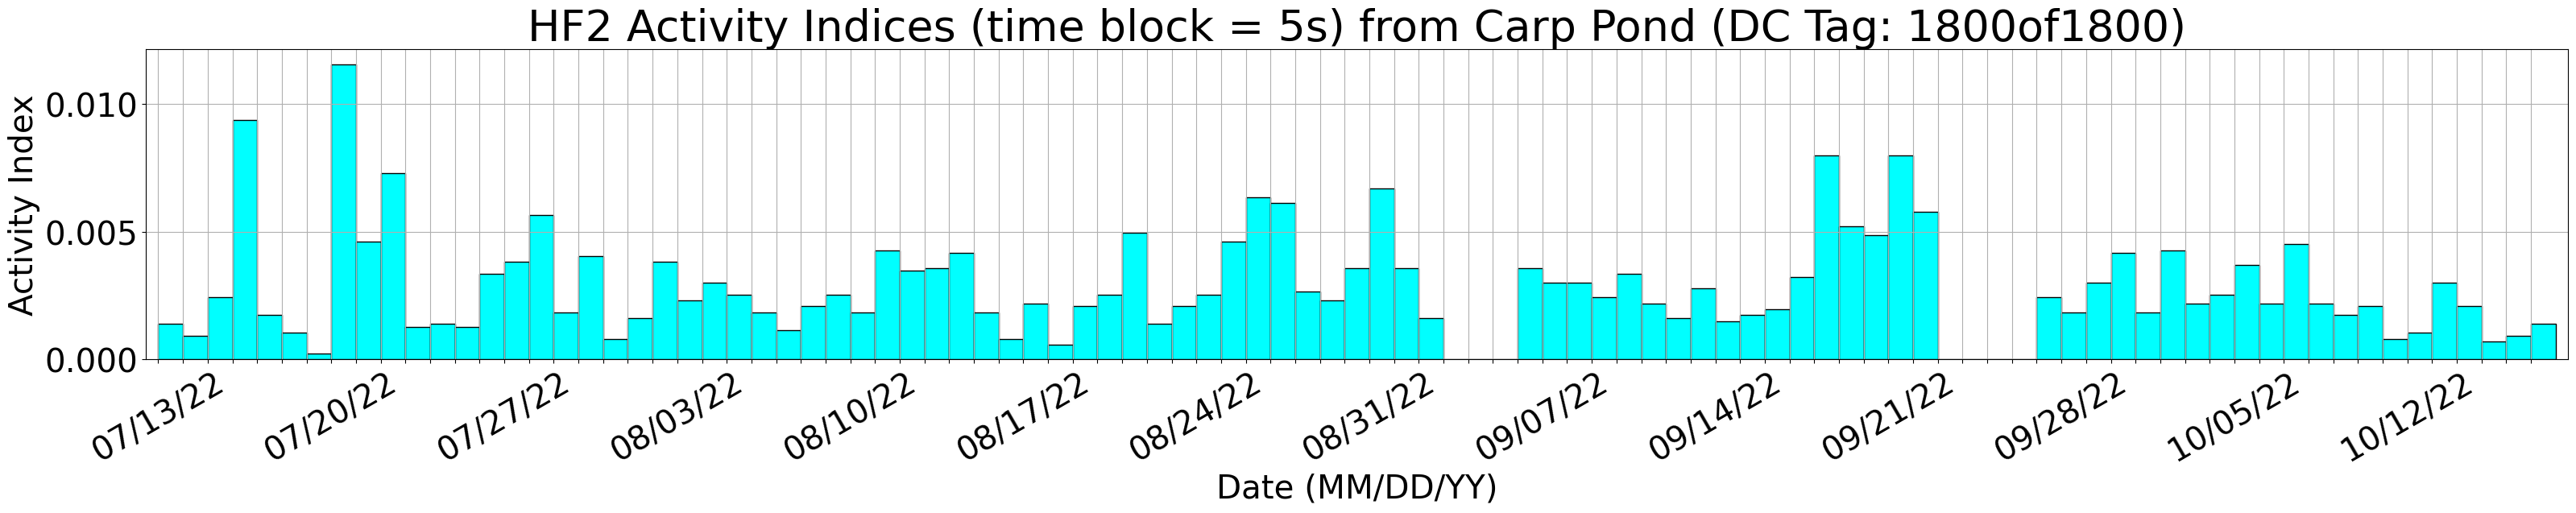

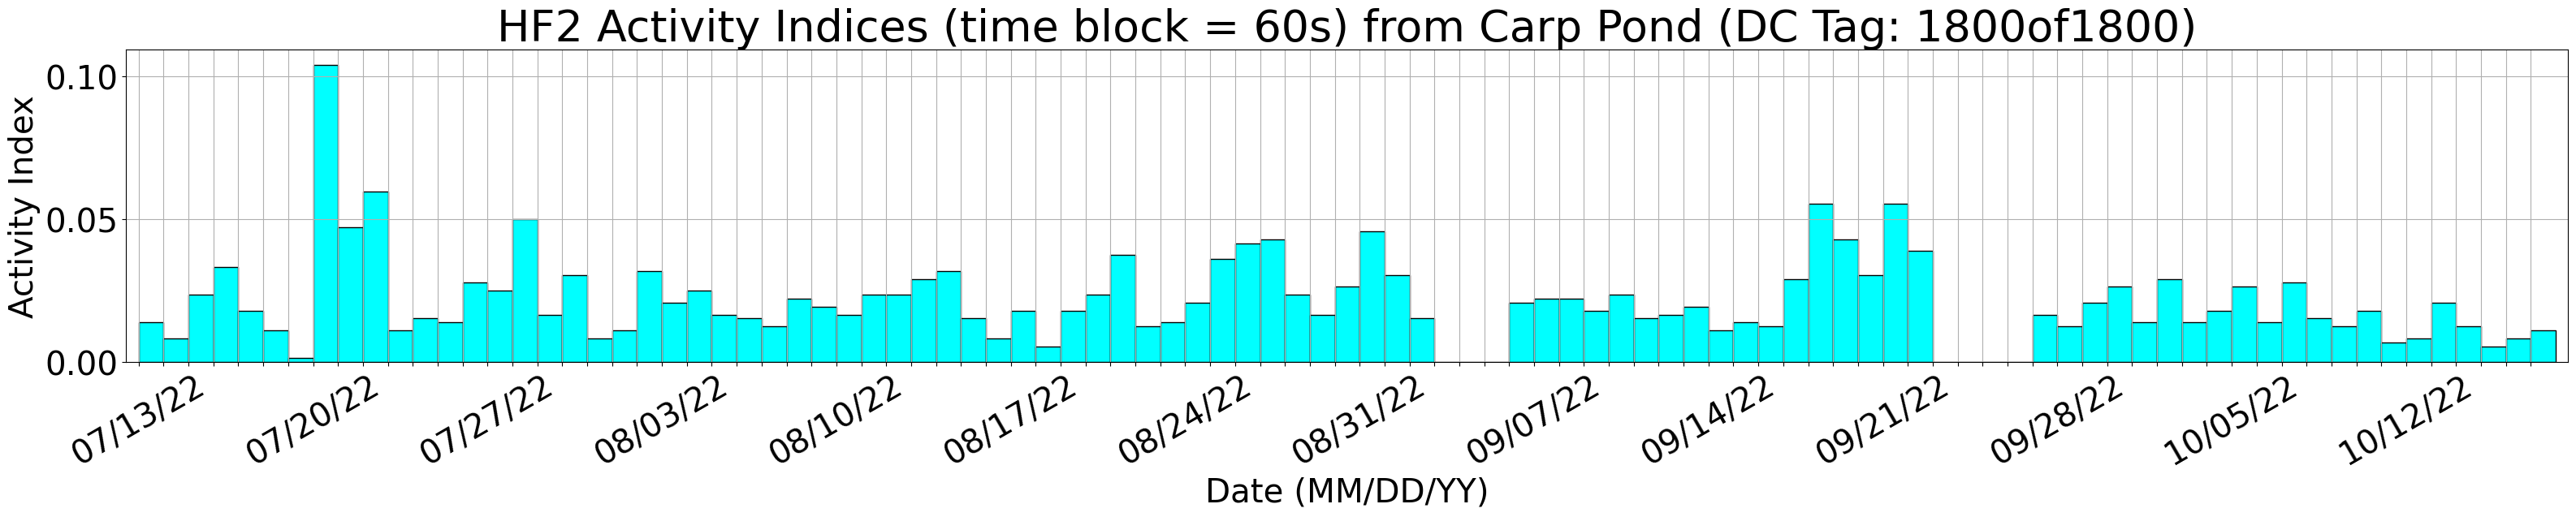

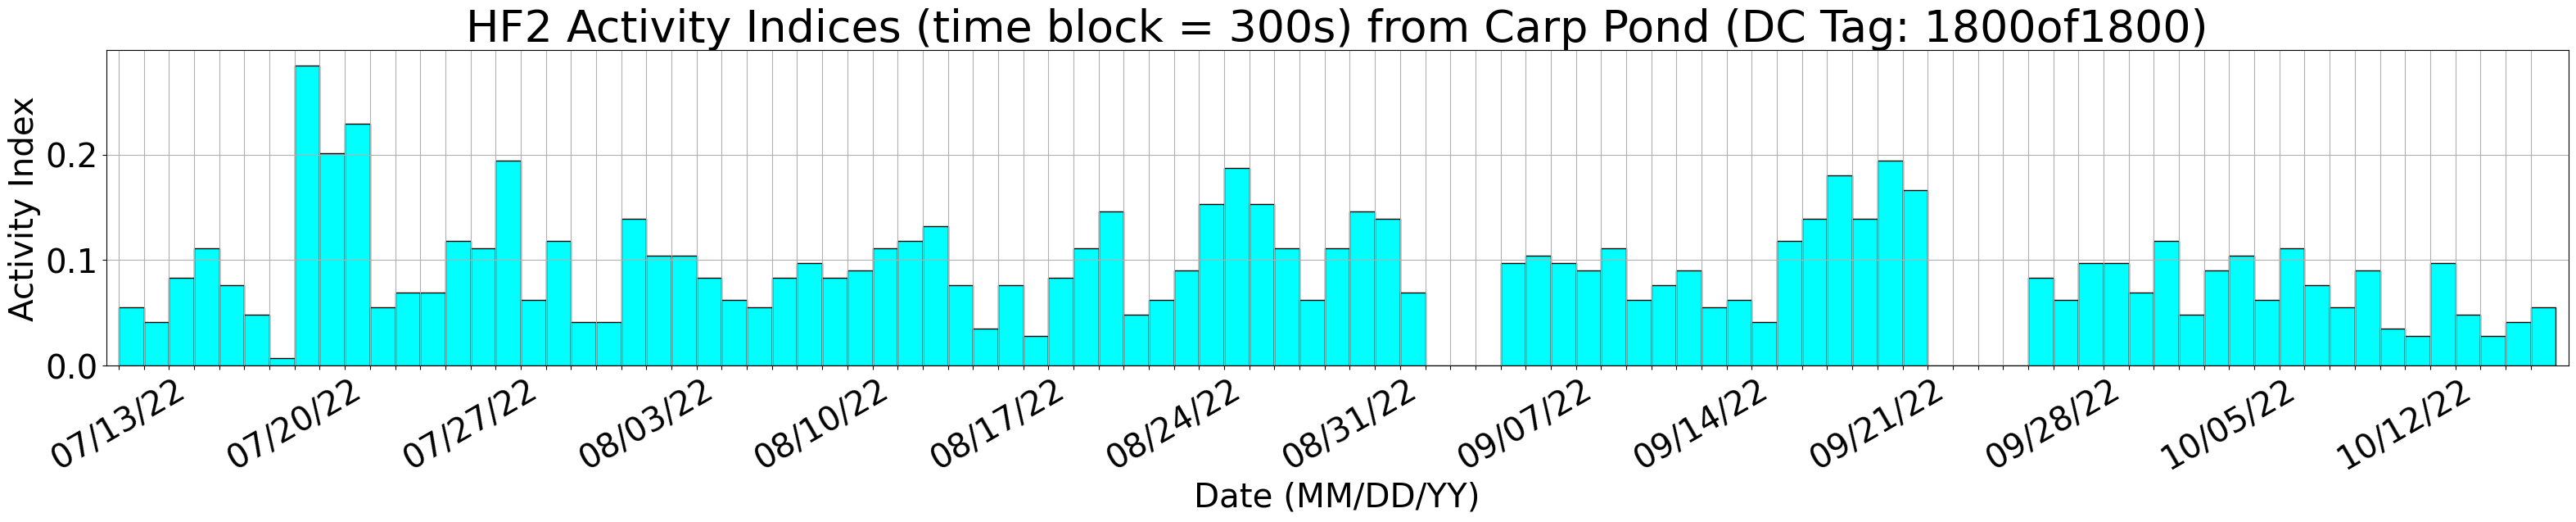

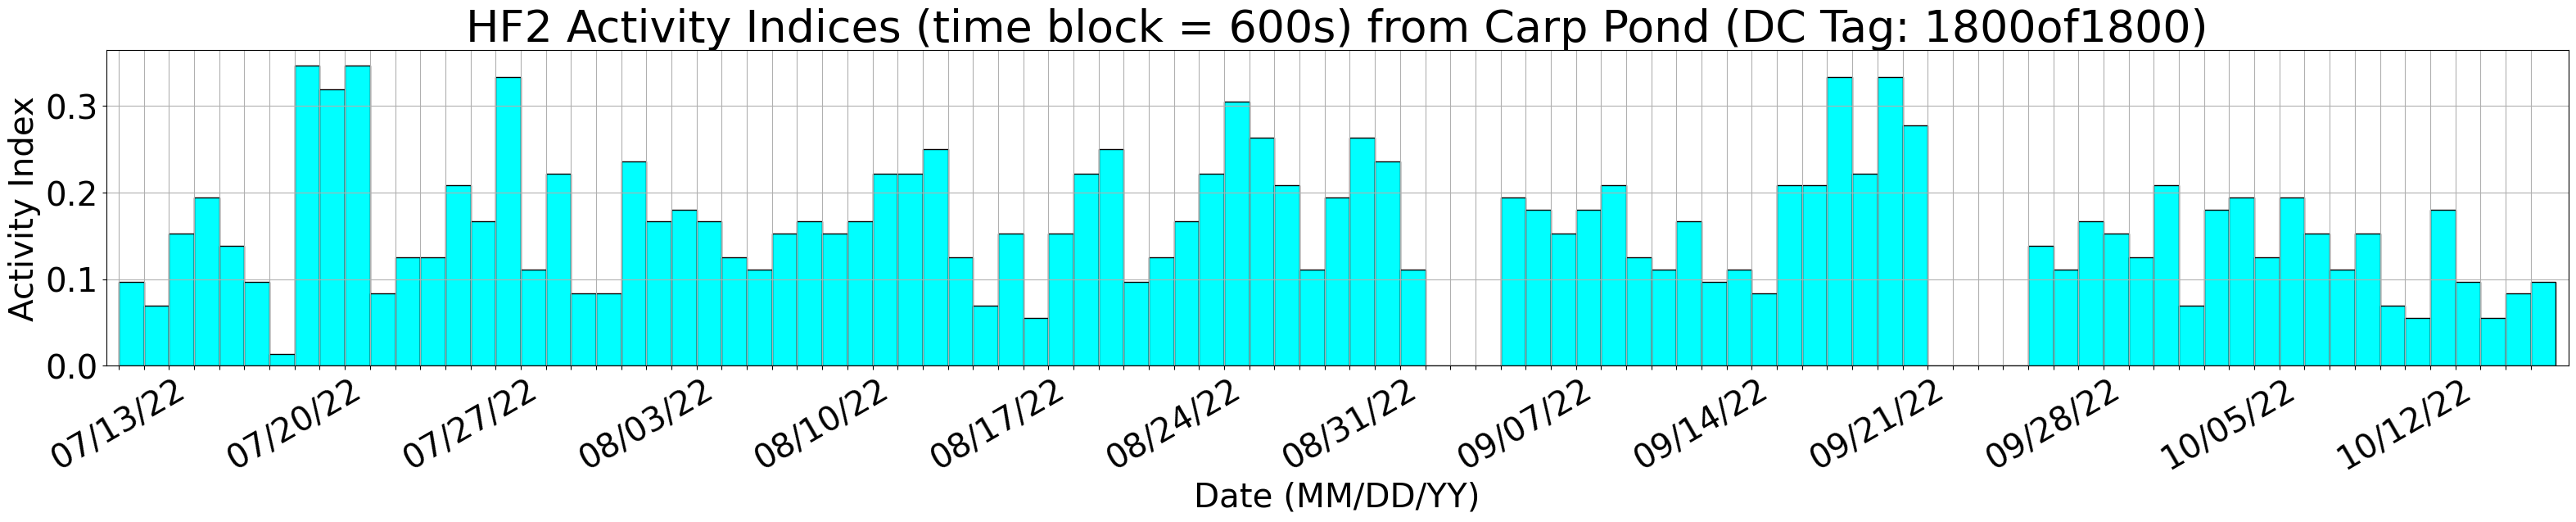

Foliage LF1


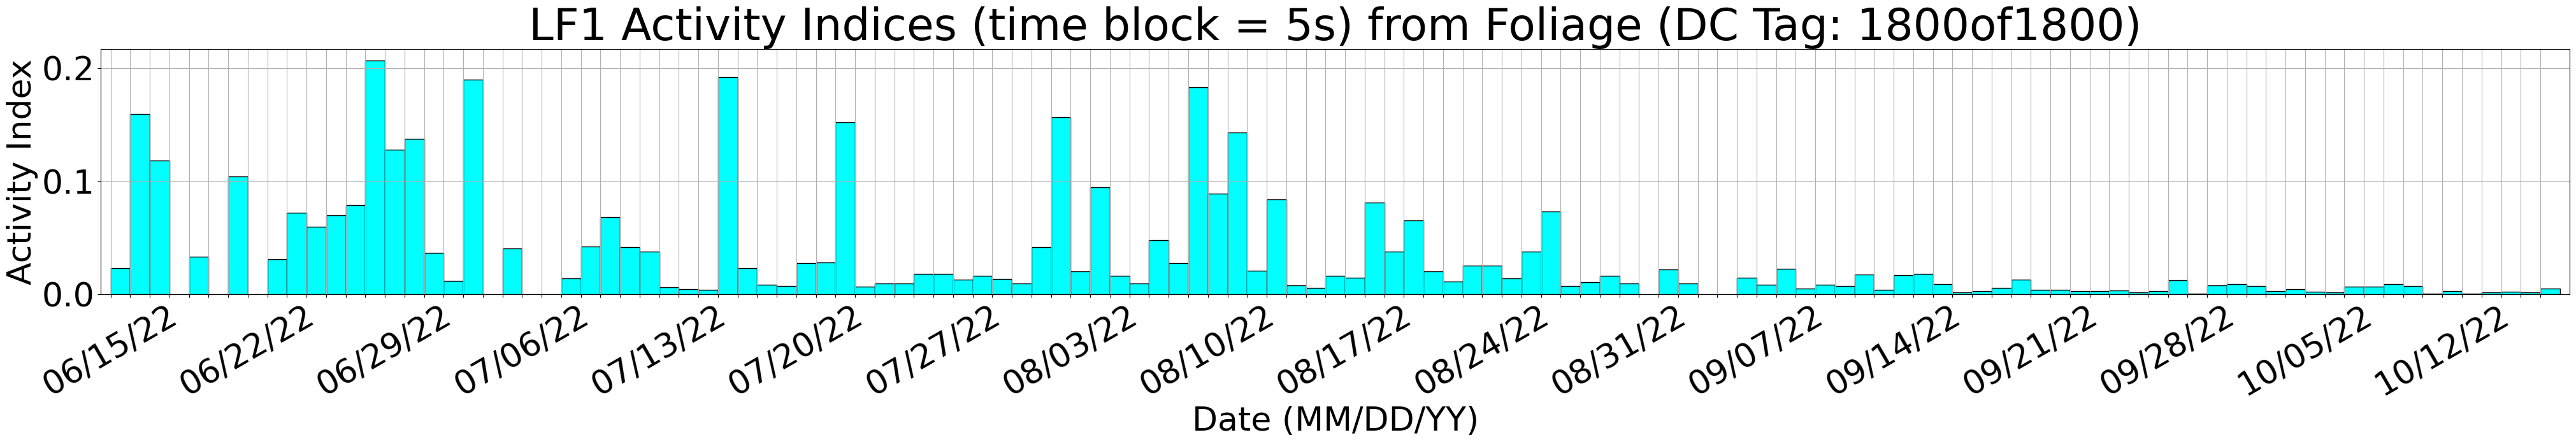

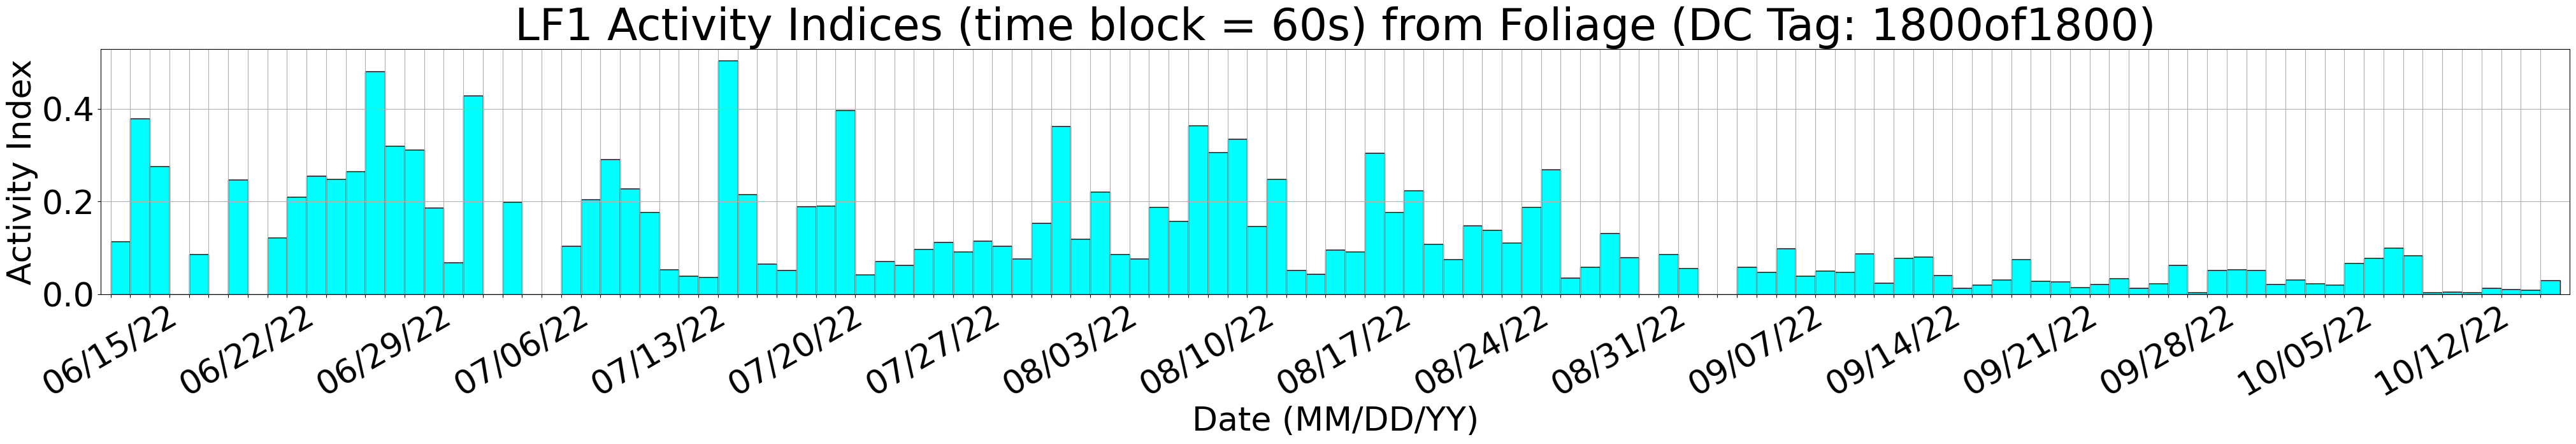

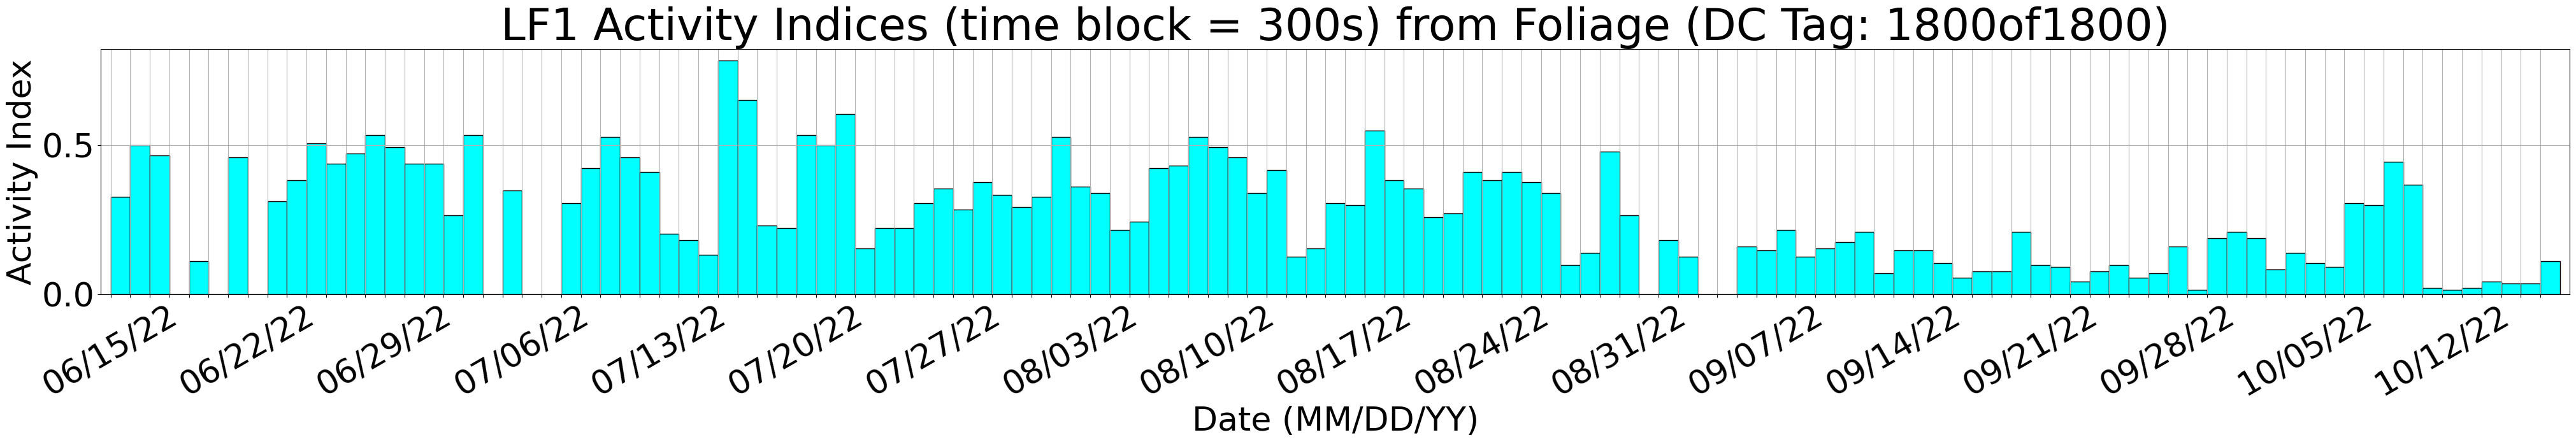

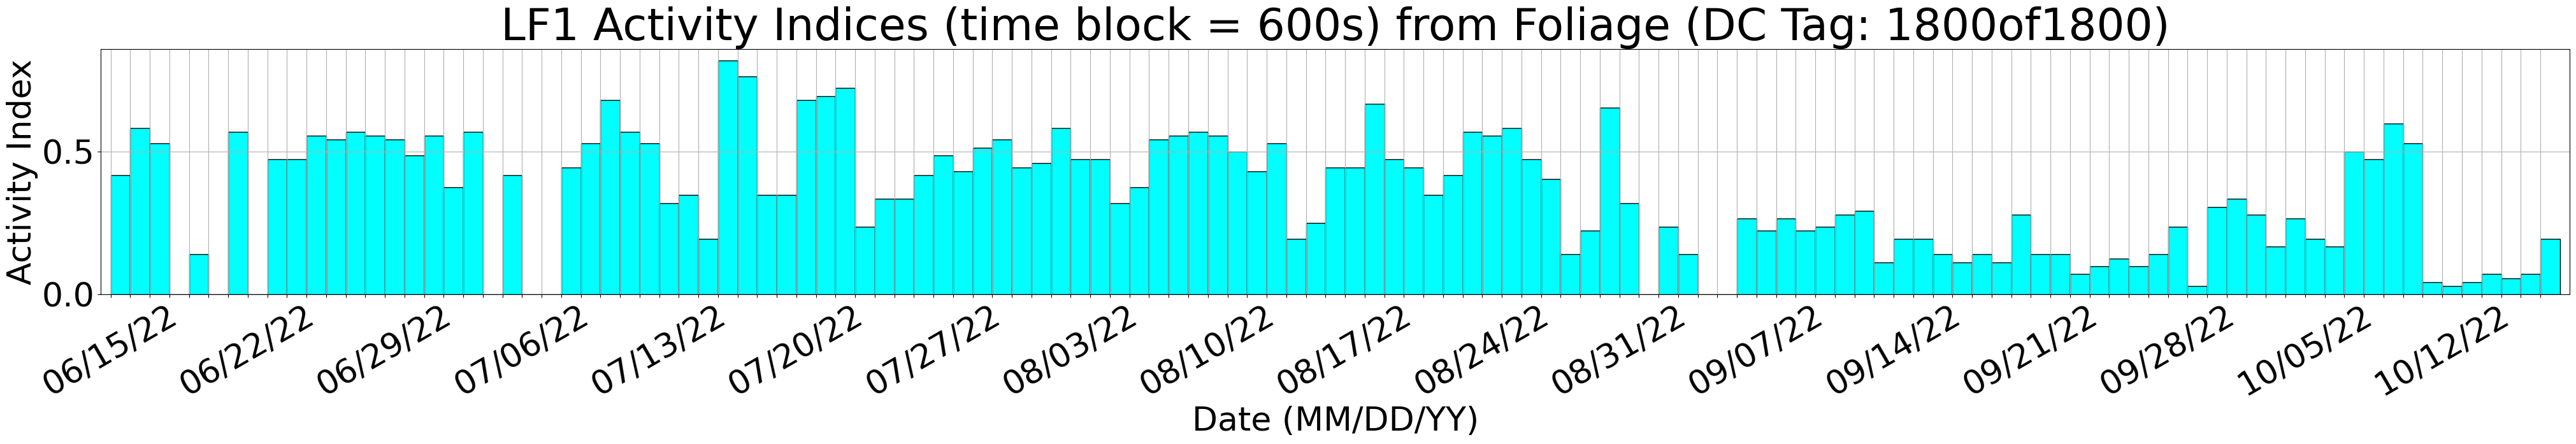

Foliage HF1


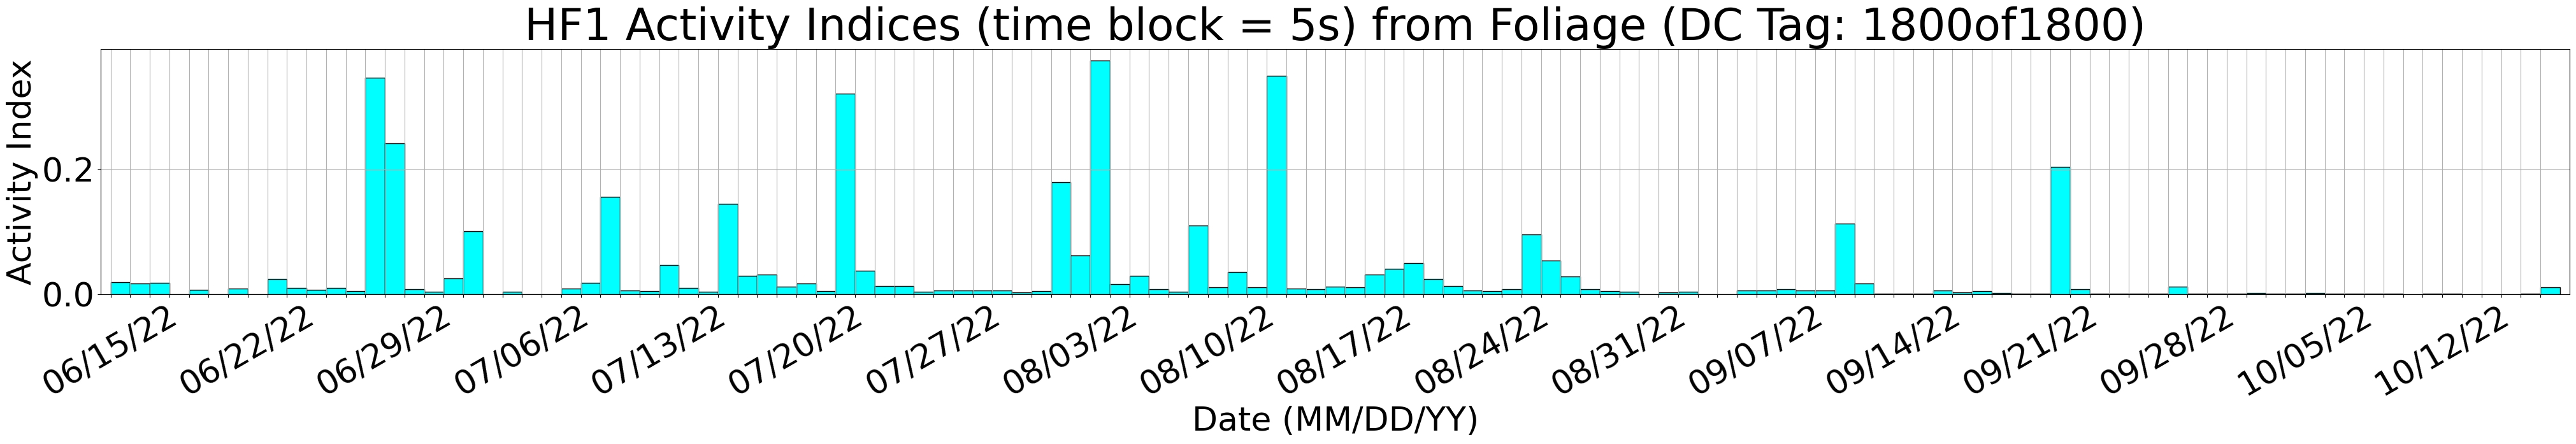

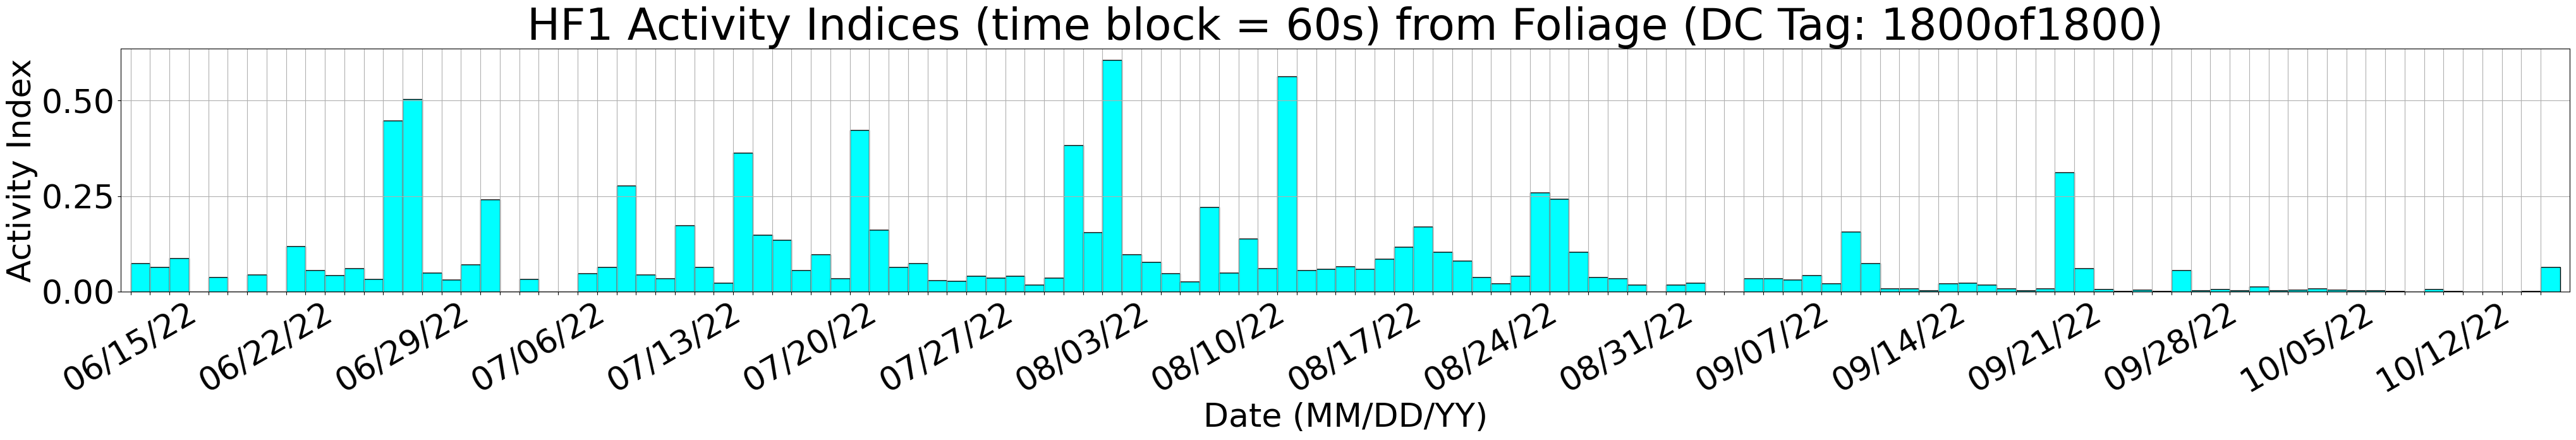

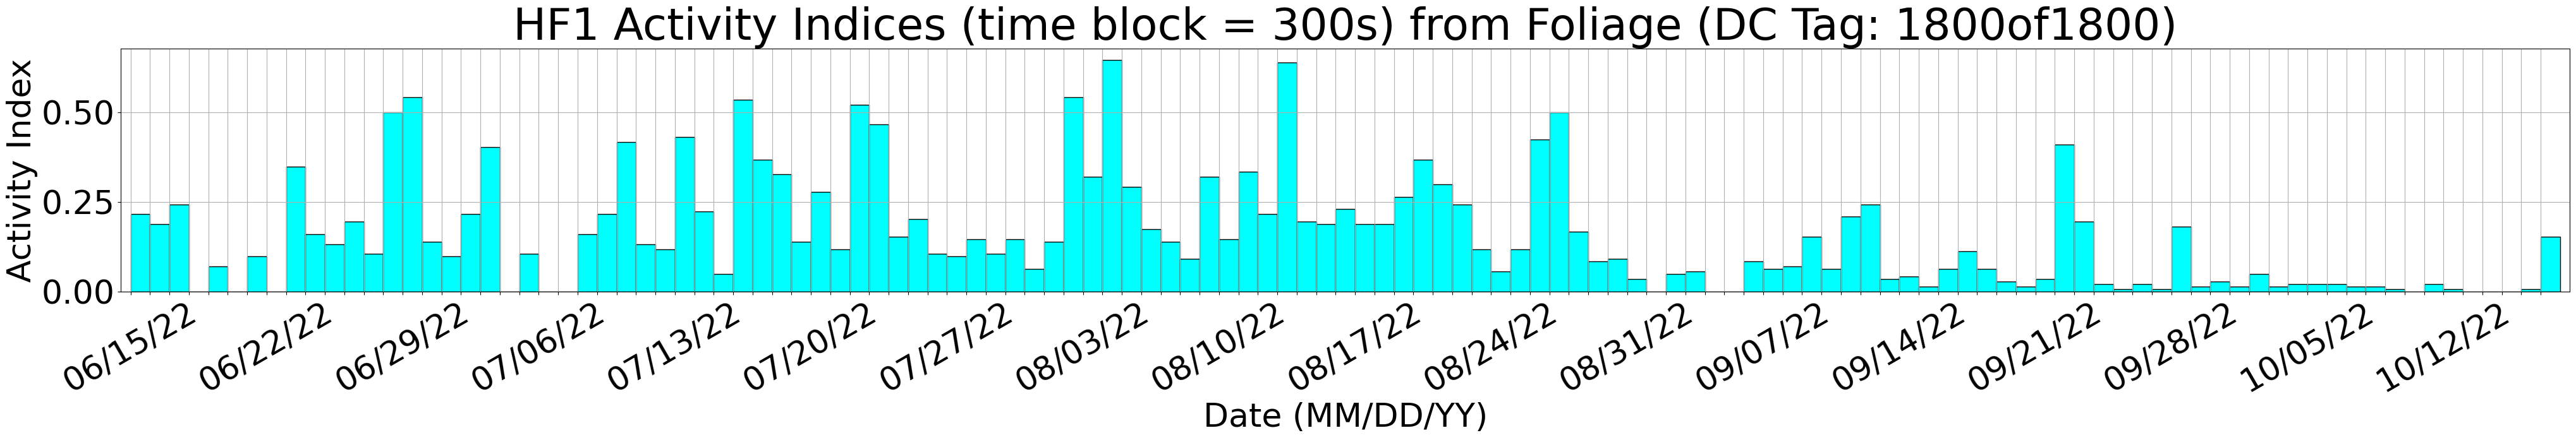

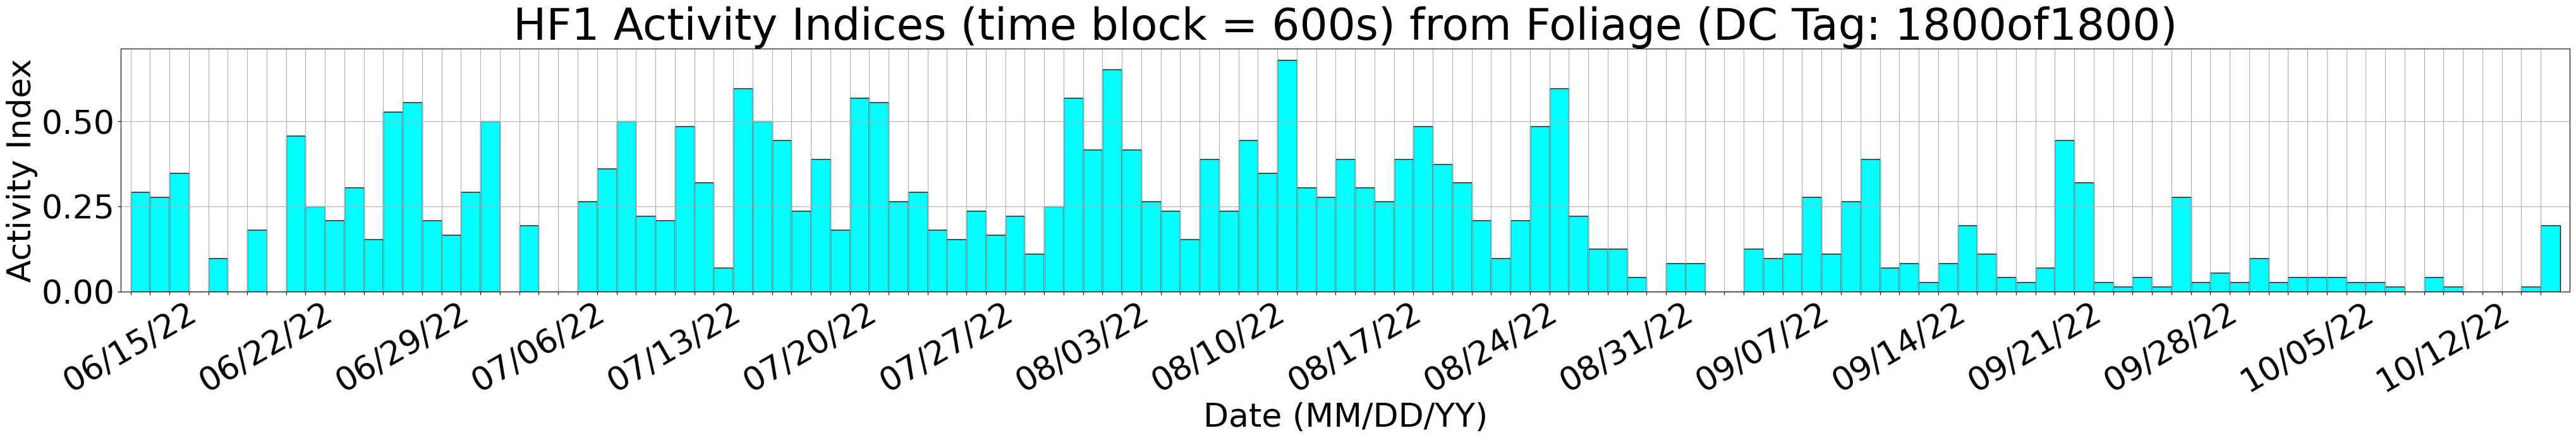

Foliage HF2


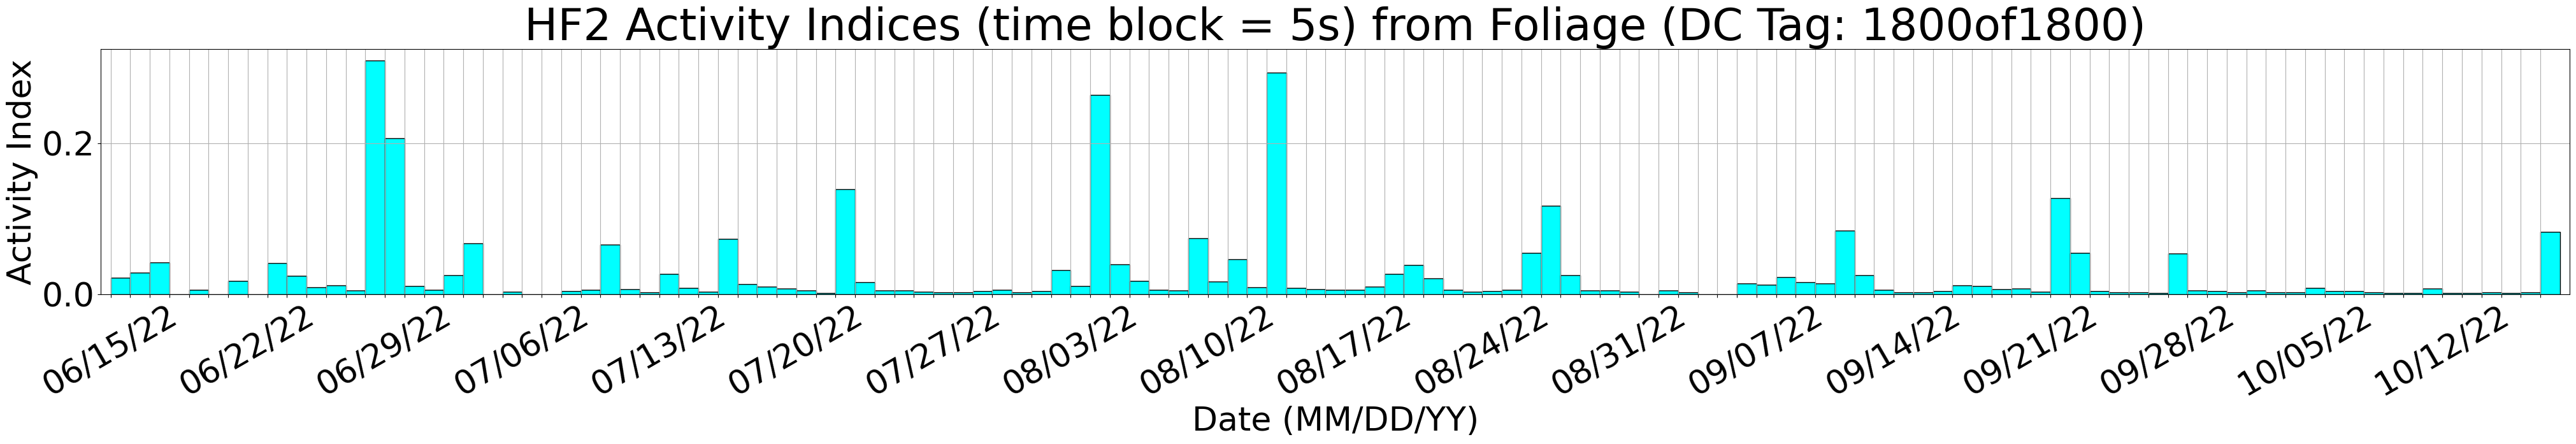

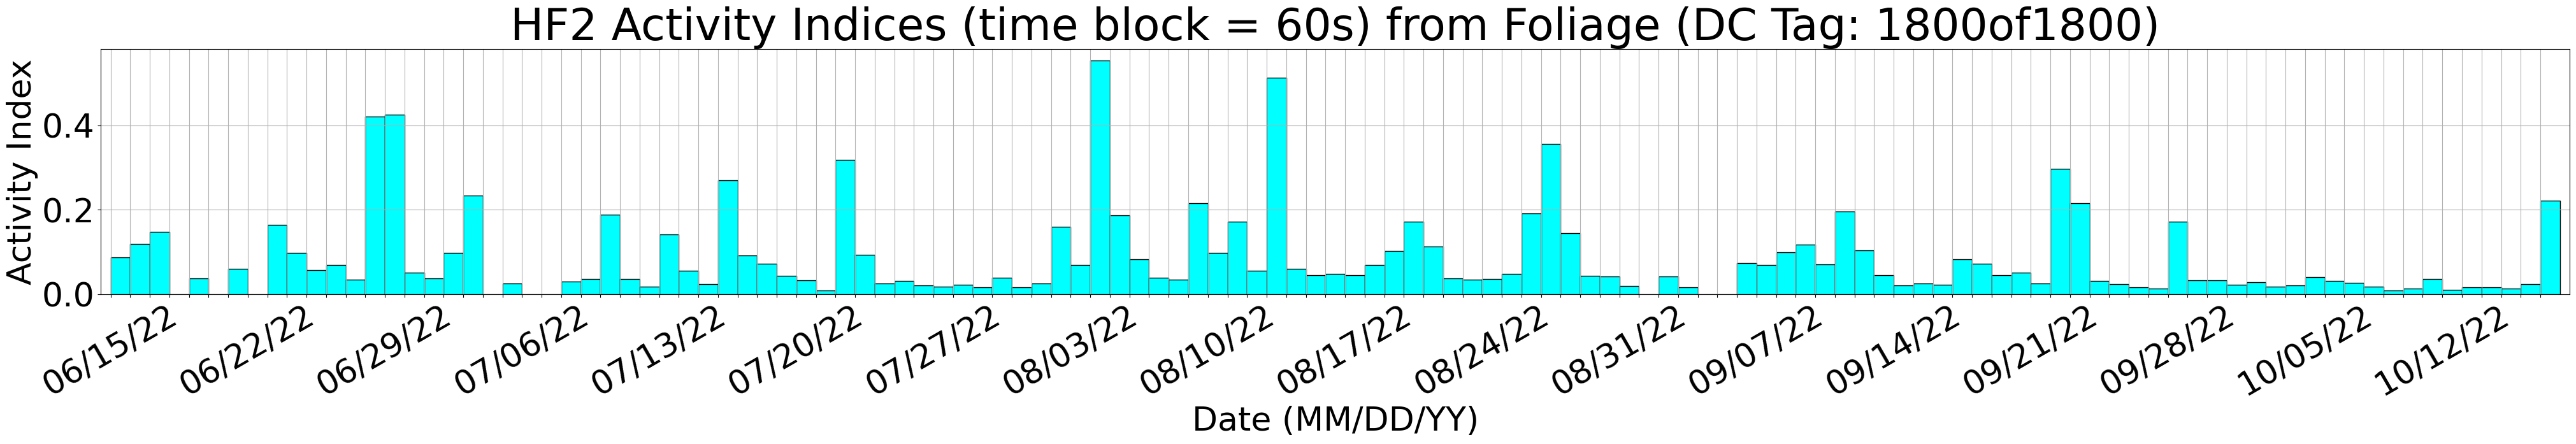

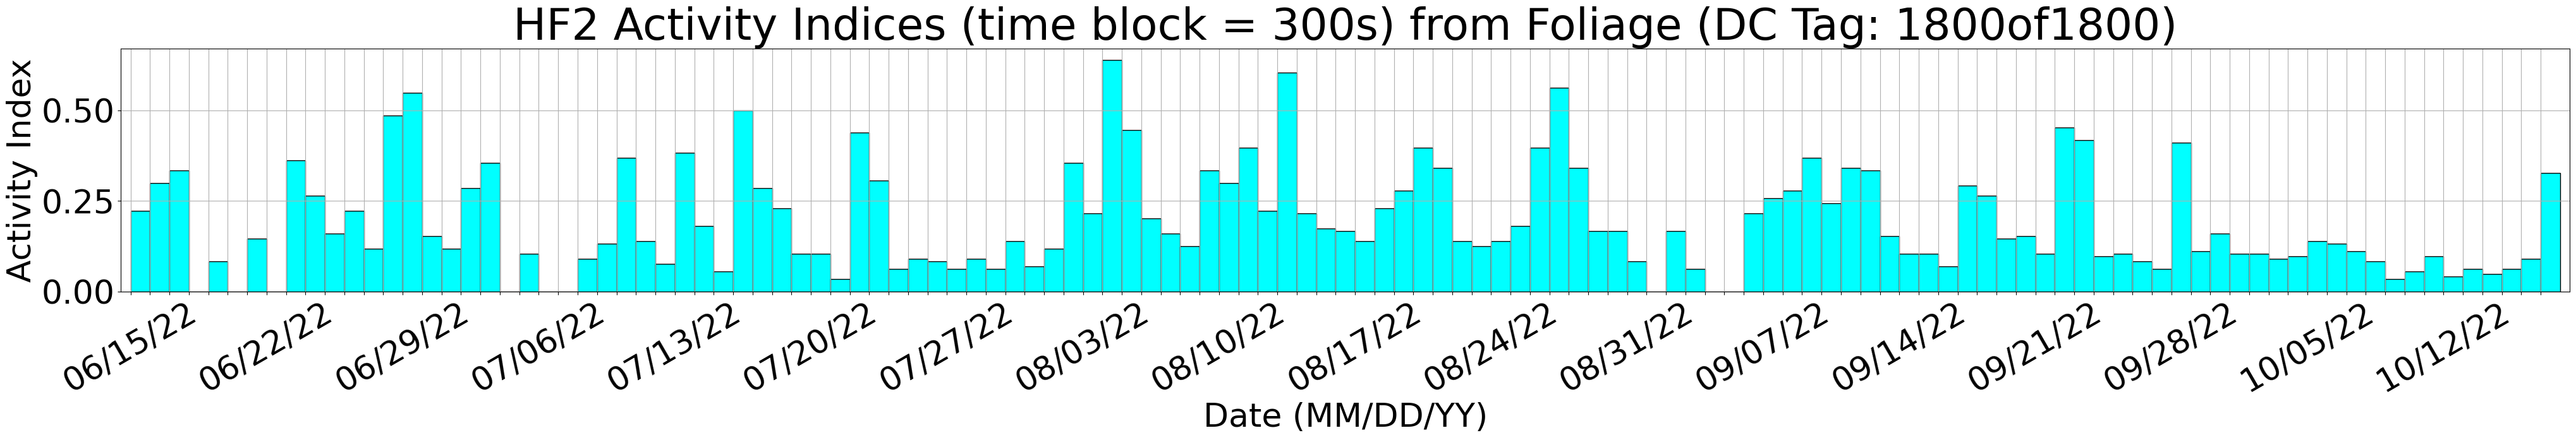

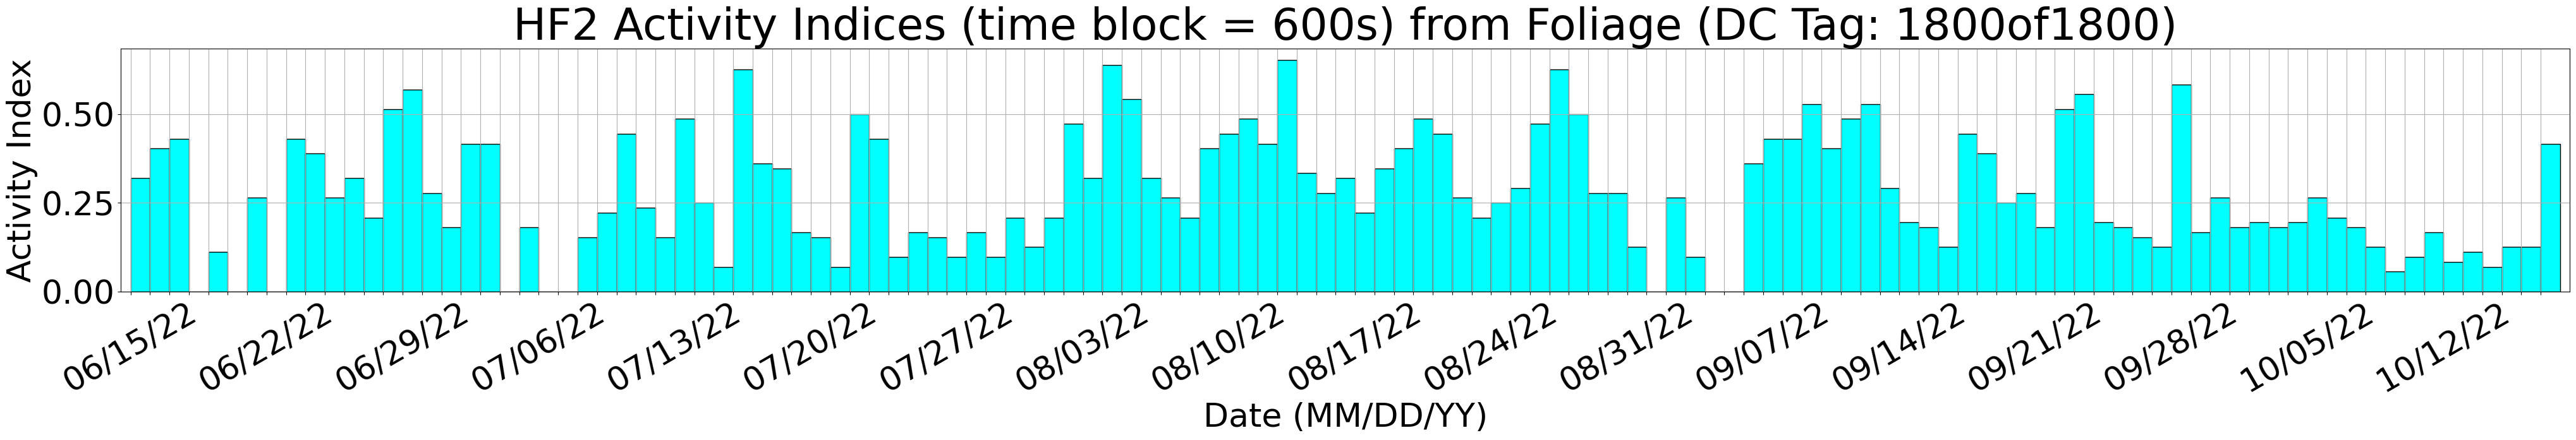

Telephone LF1


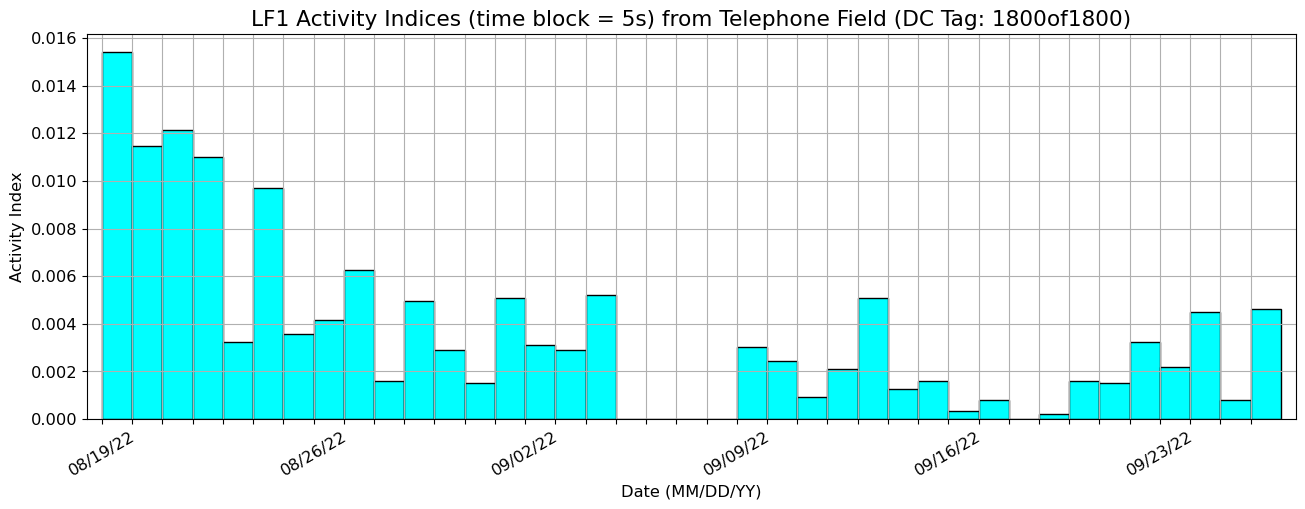

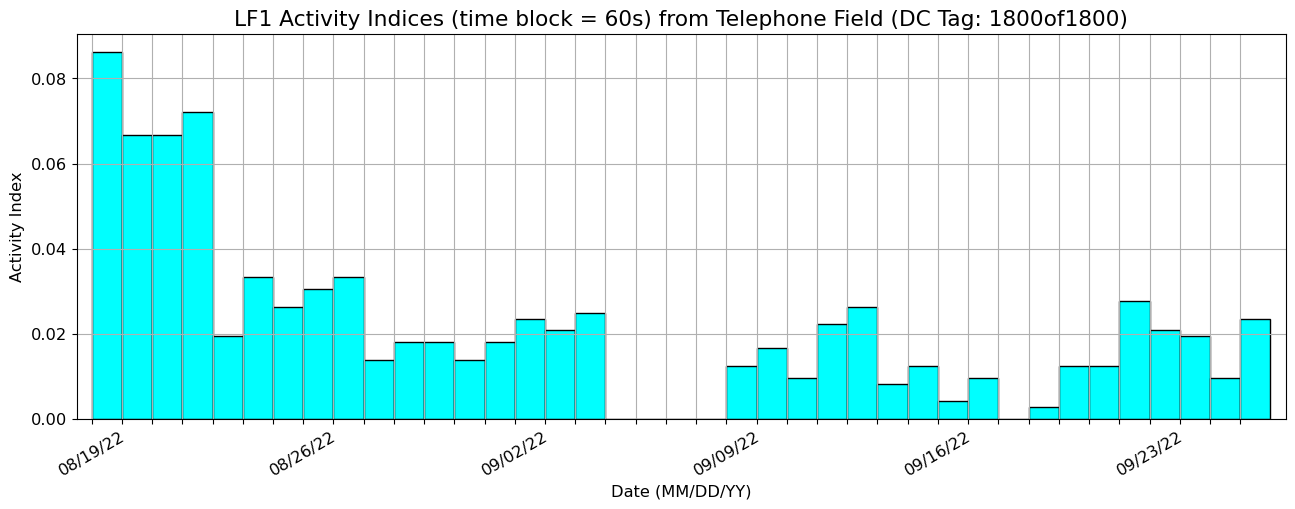

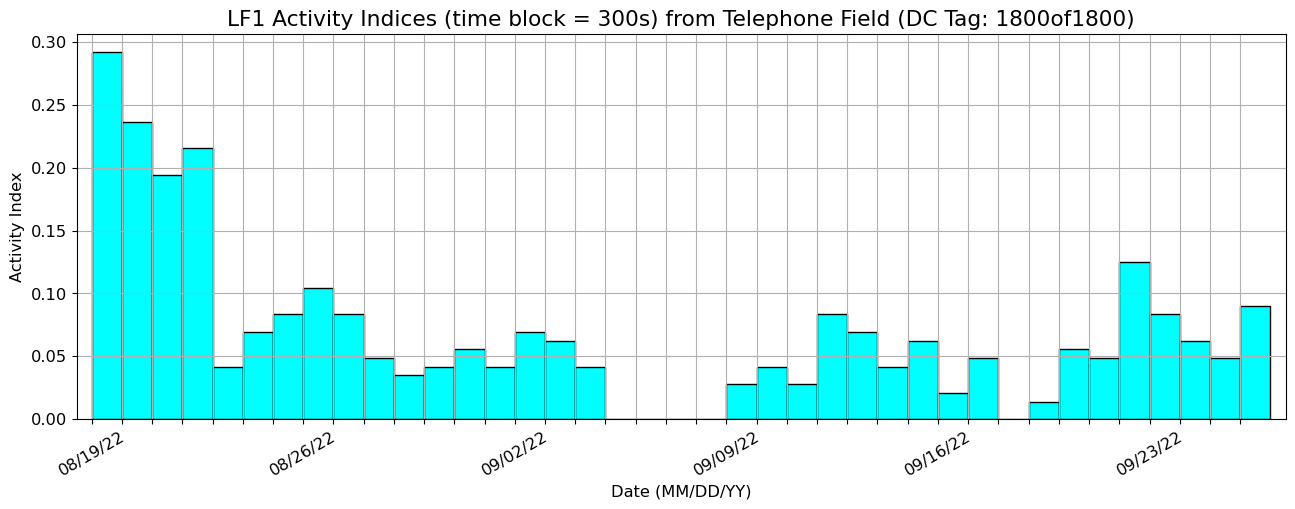

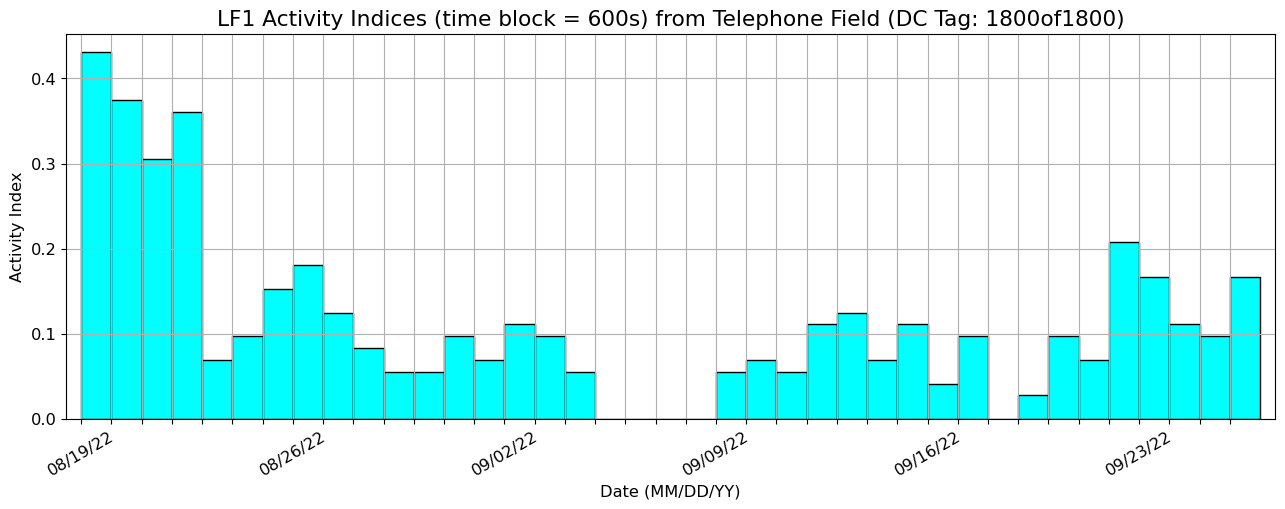

Telephone HF1


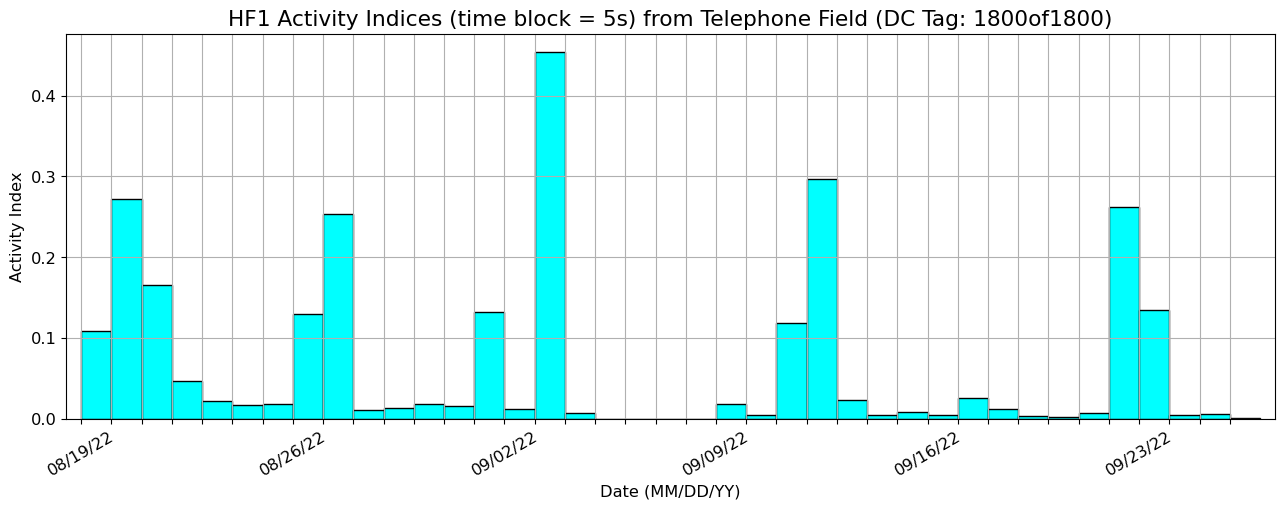

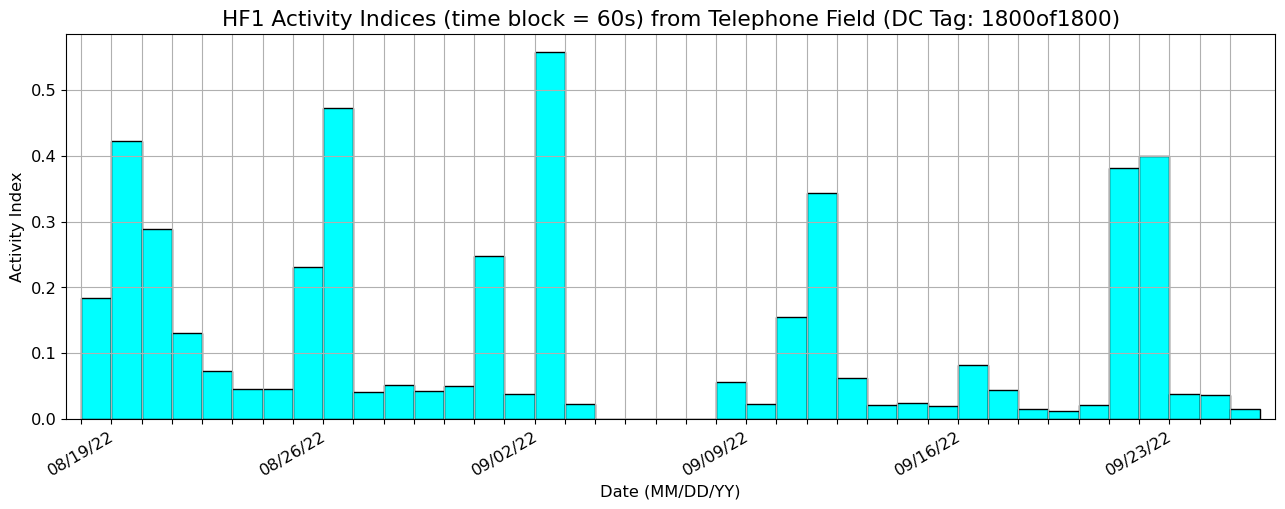

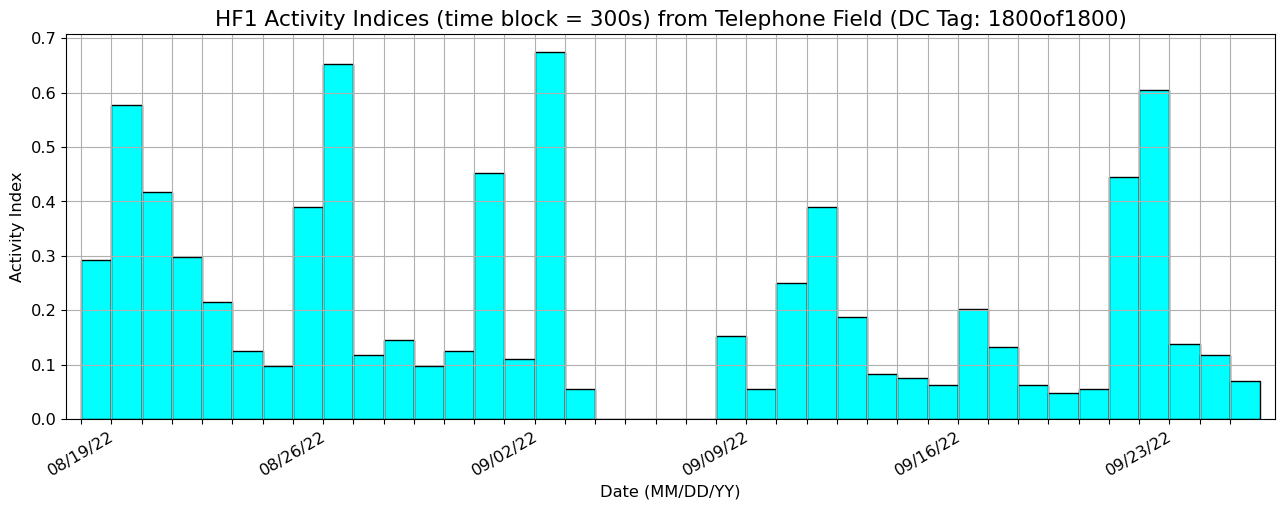

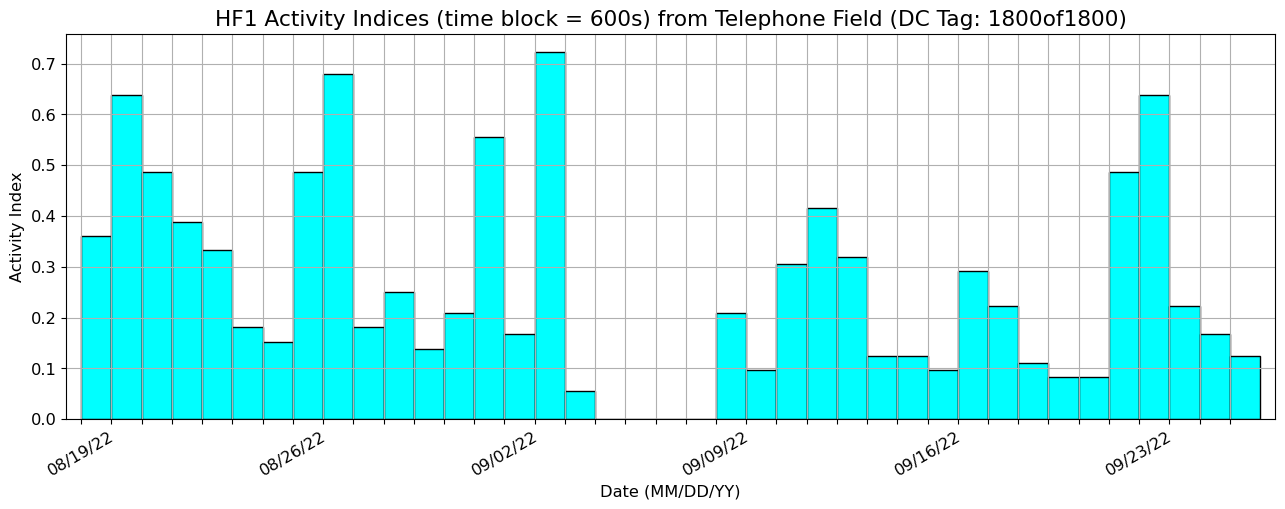

Telephone HF2


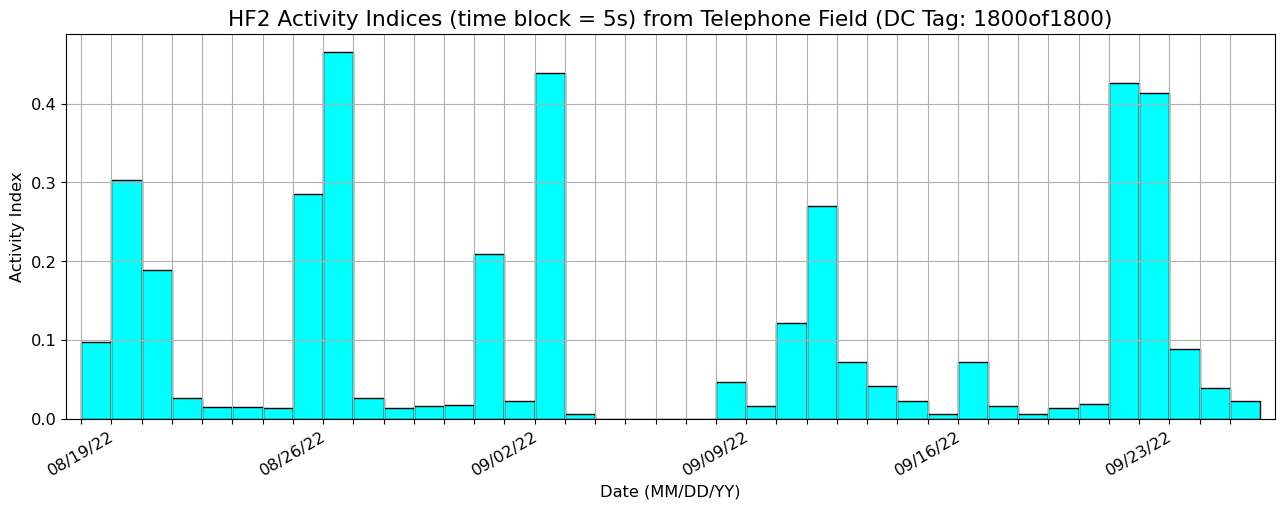

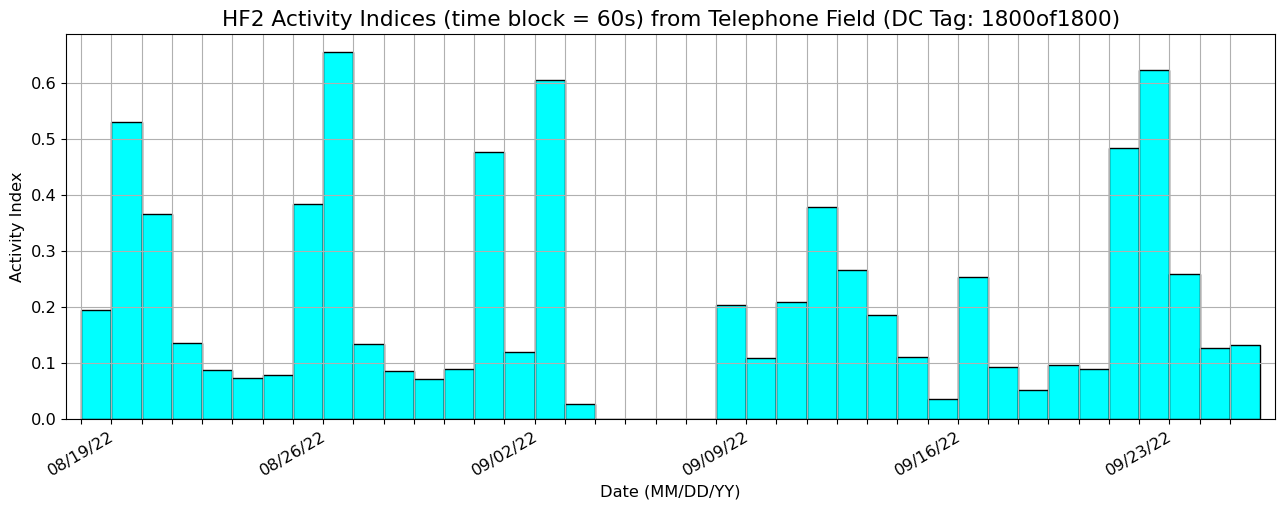

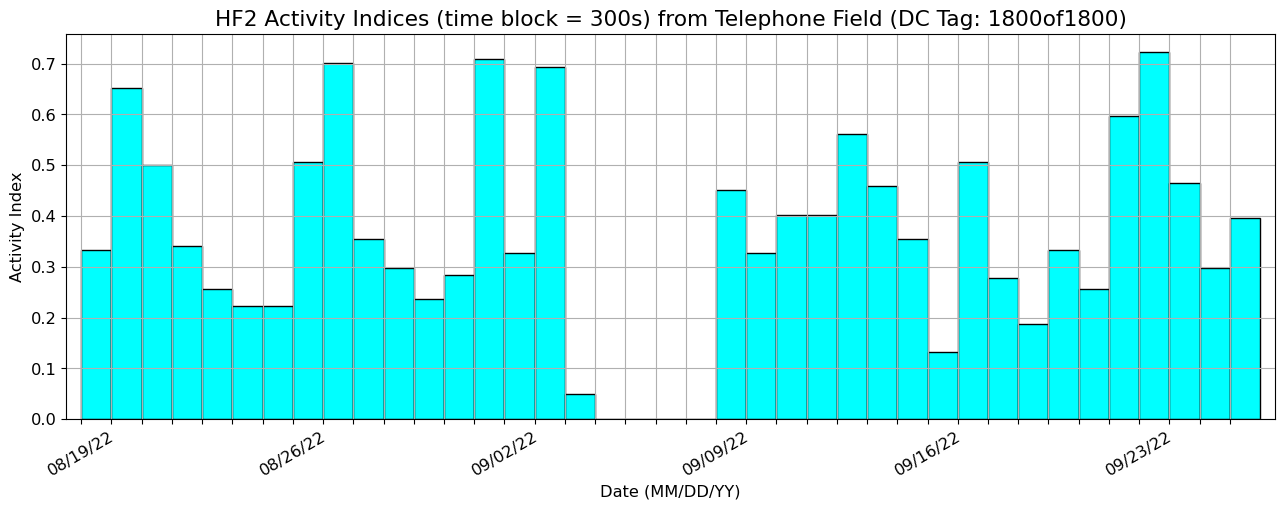

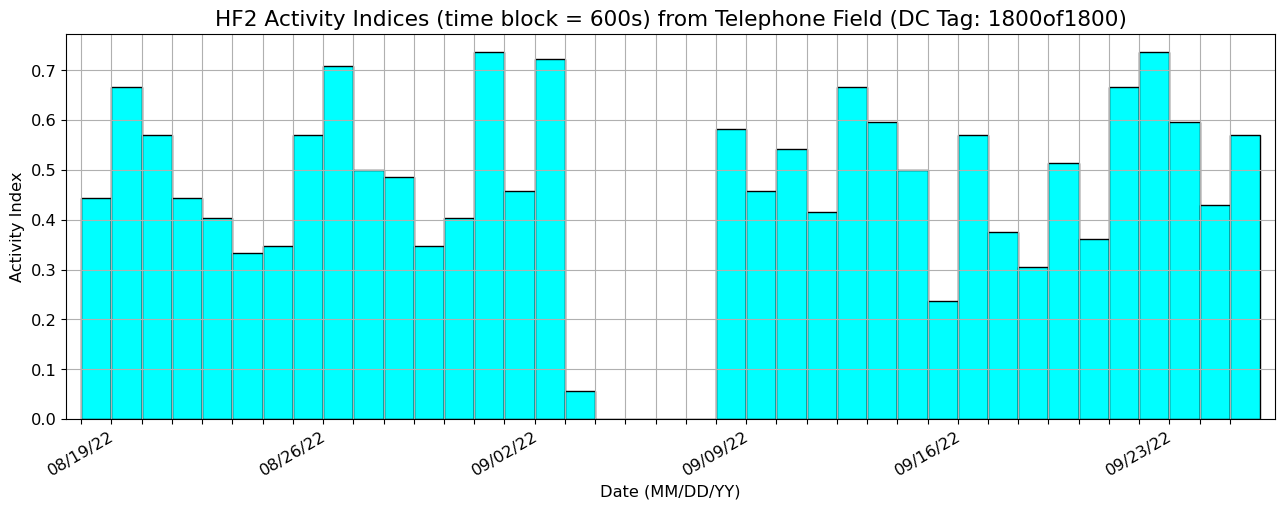

Central LF1


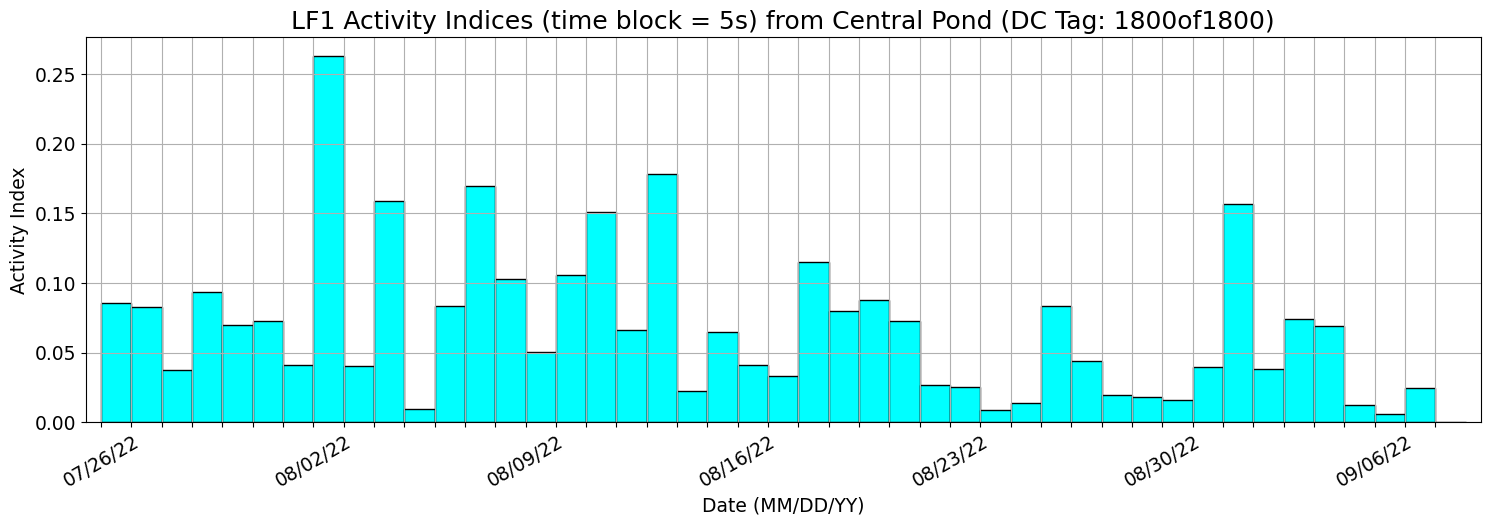

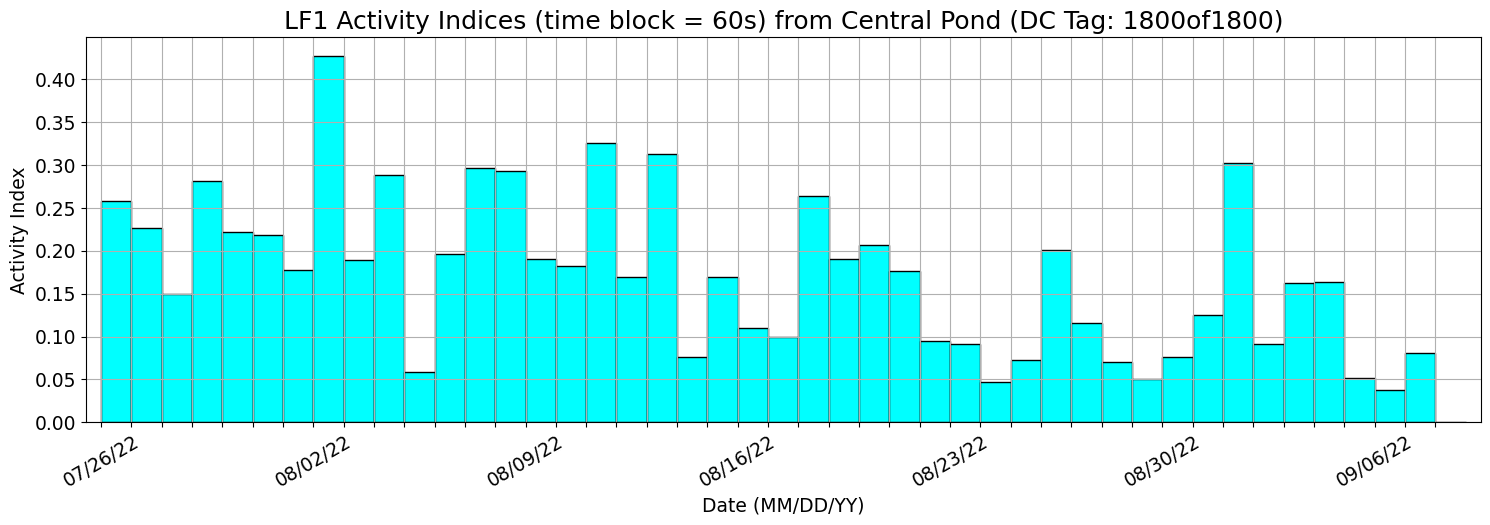

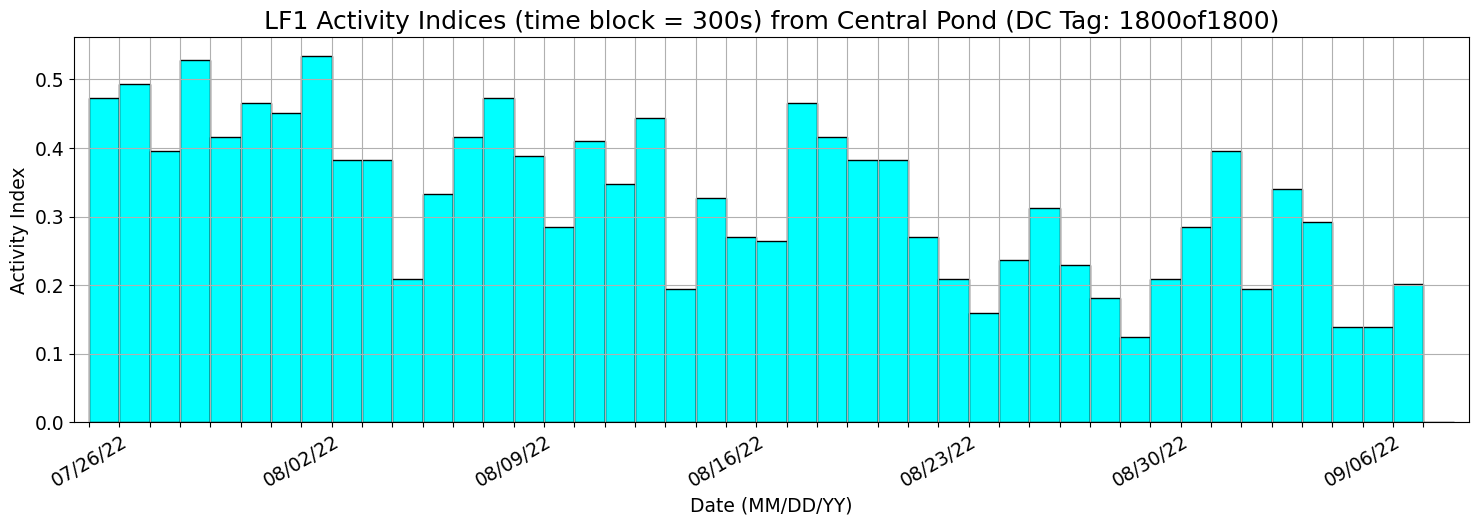

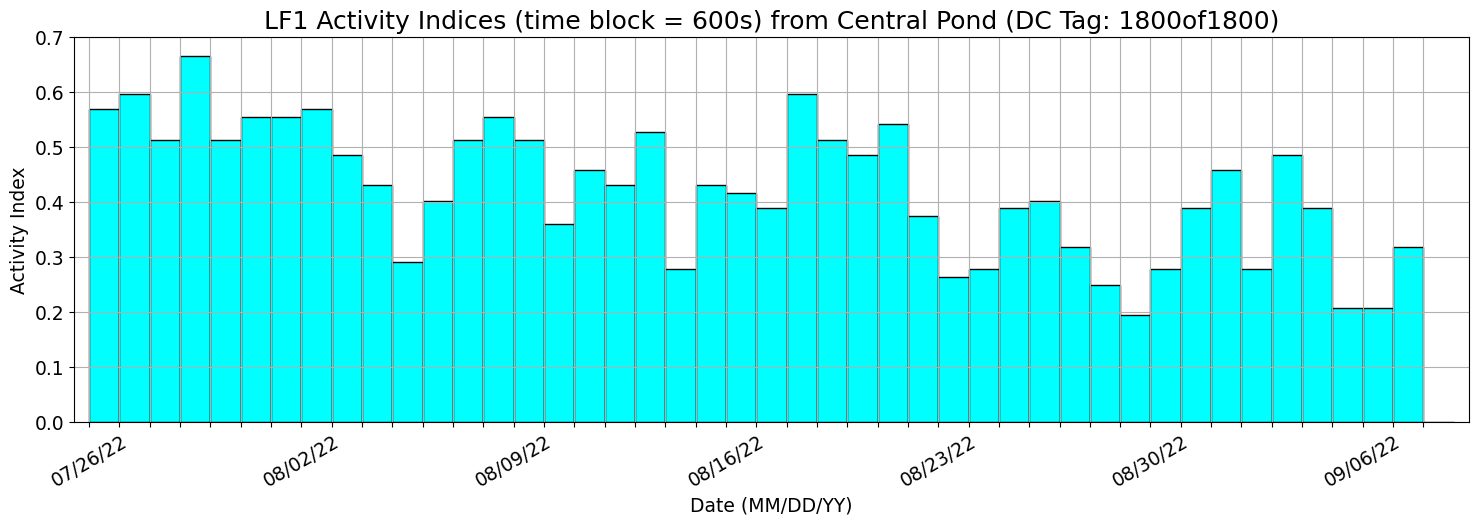

Central HF1


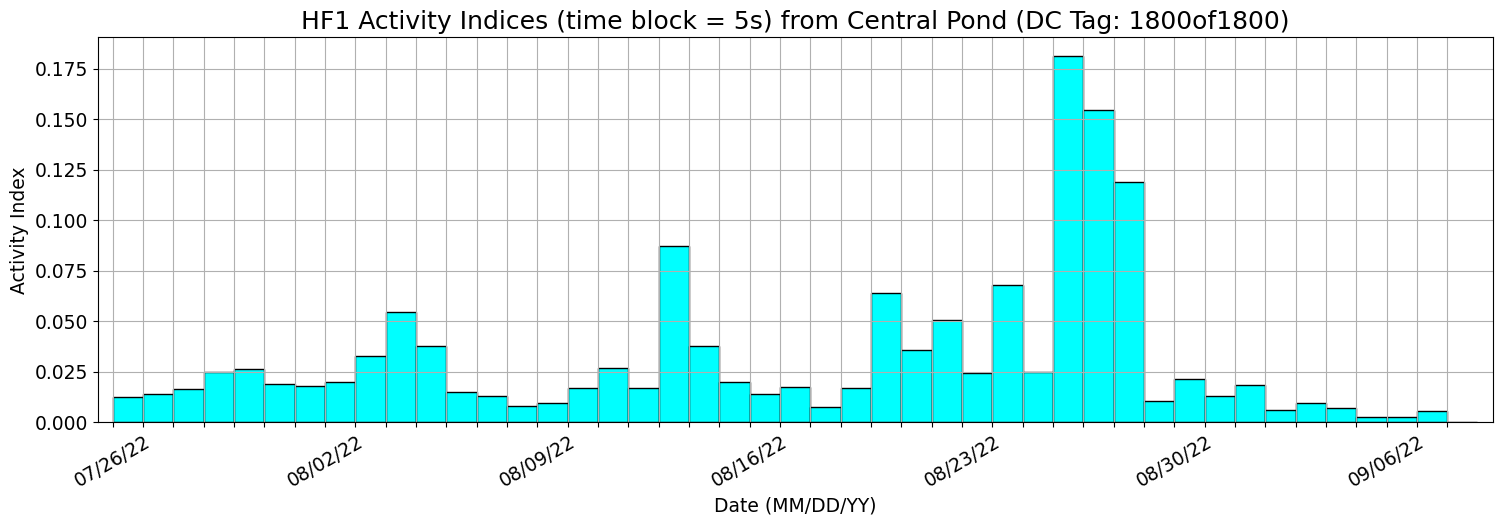

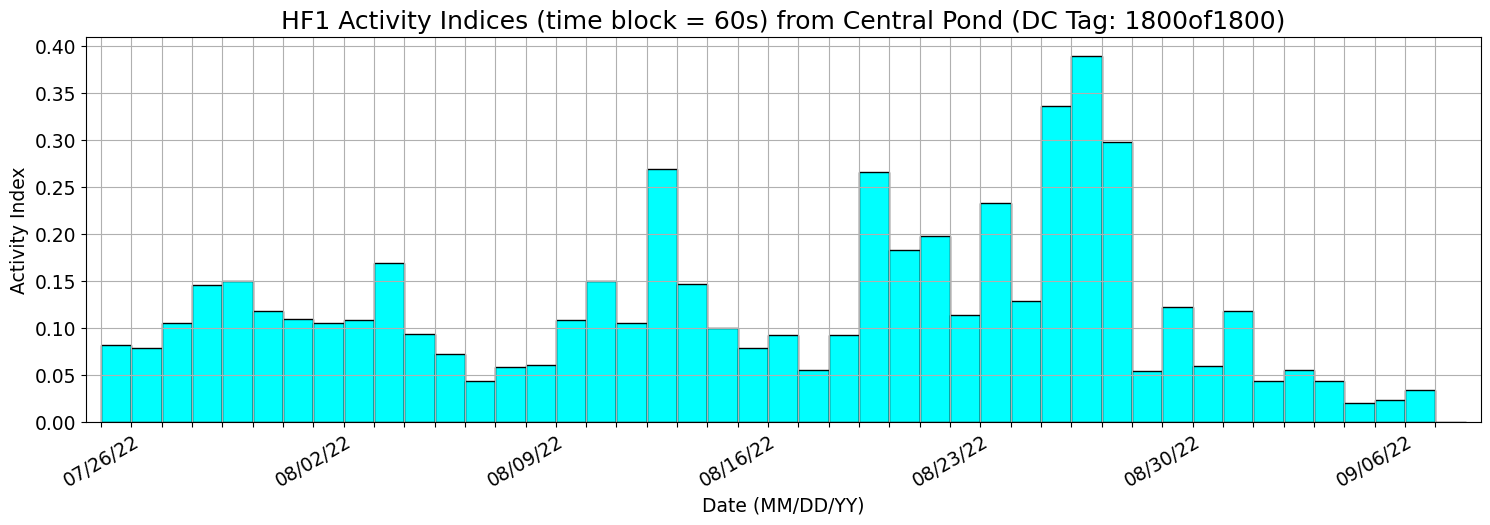

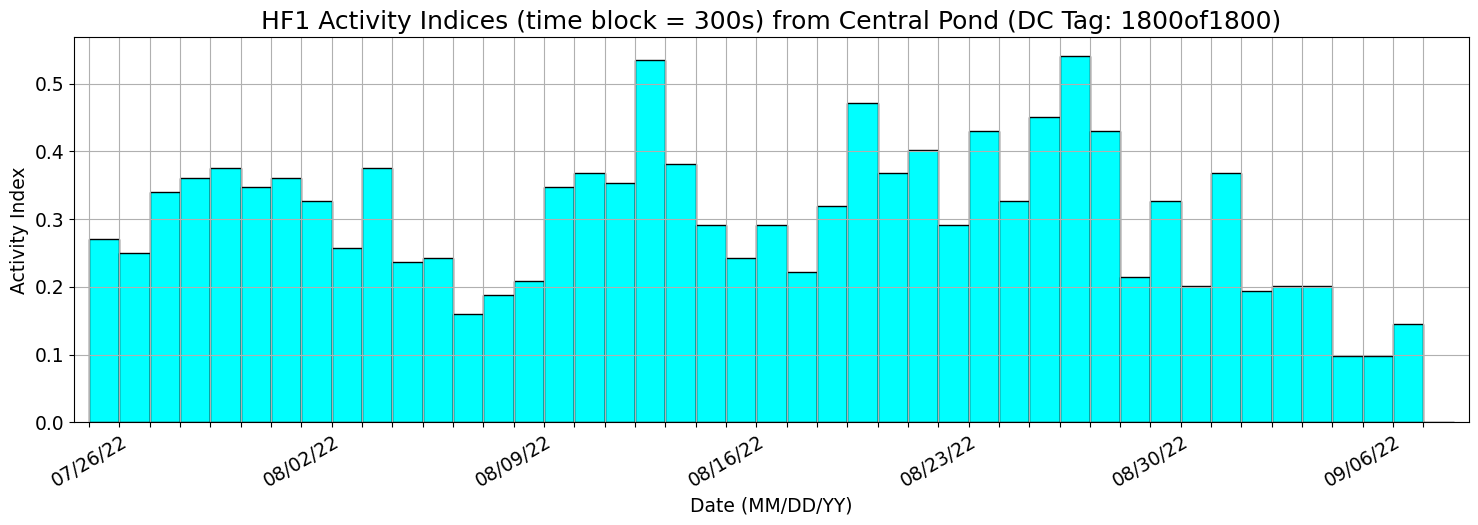

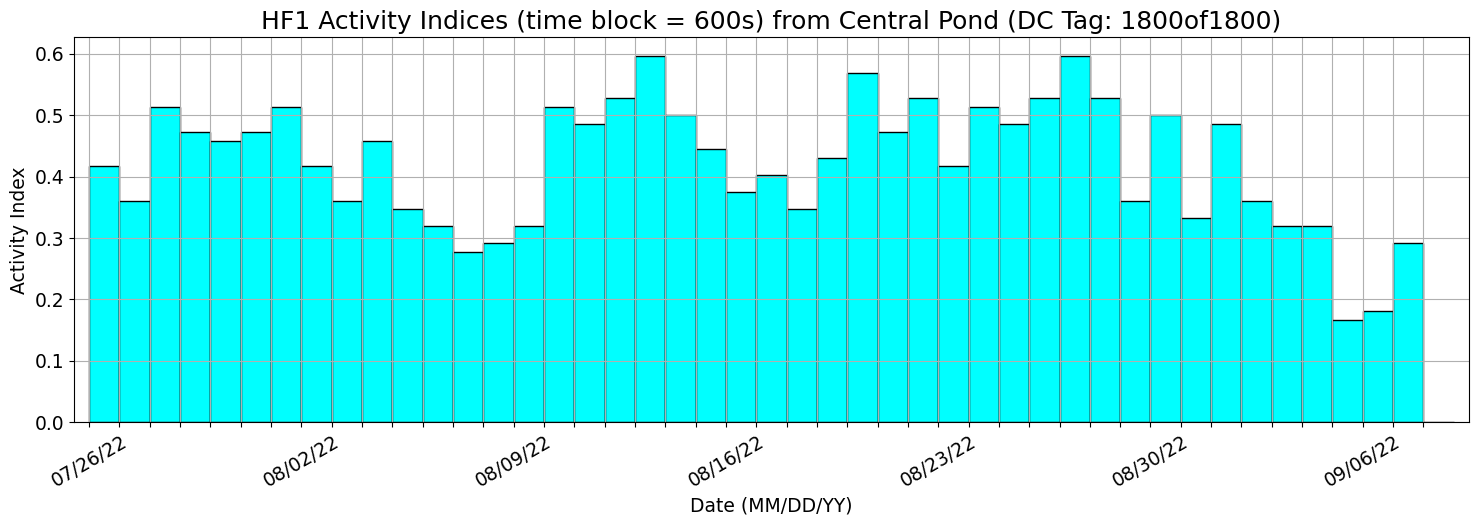

Central HF2


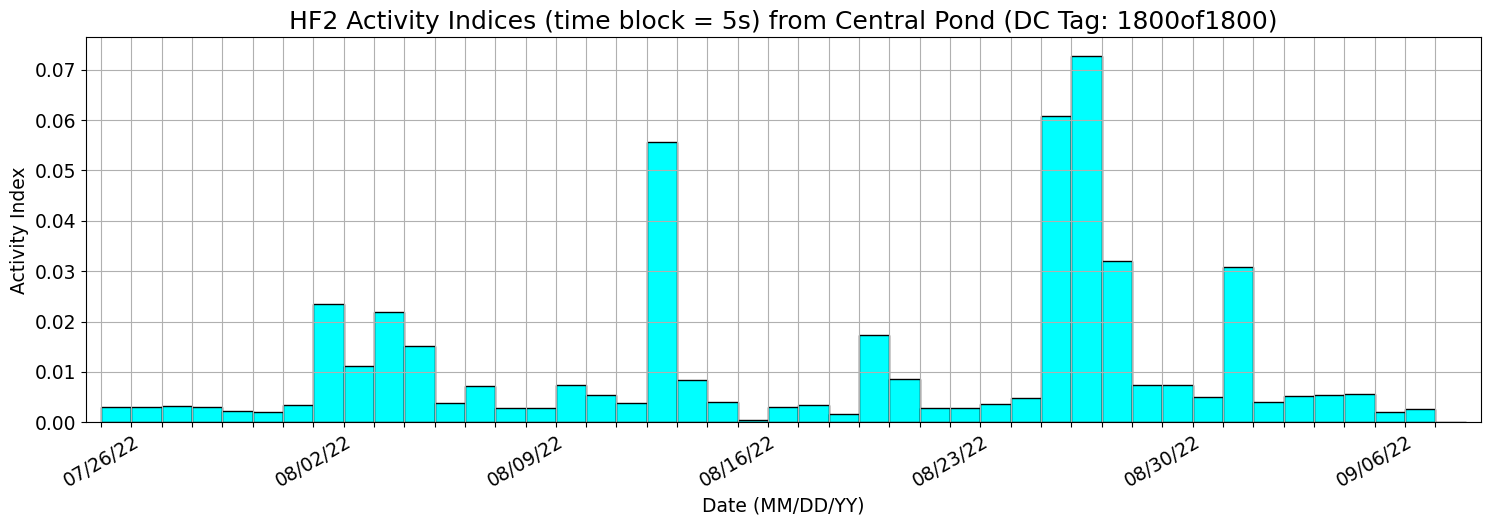

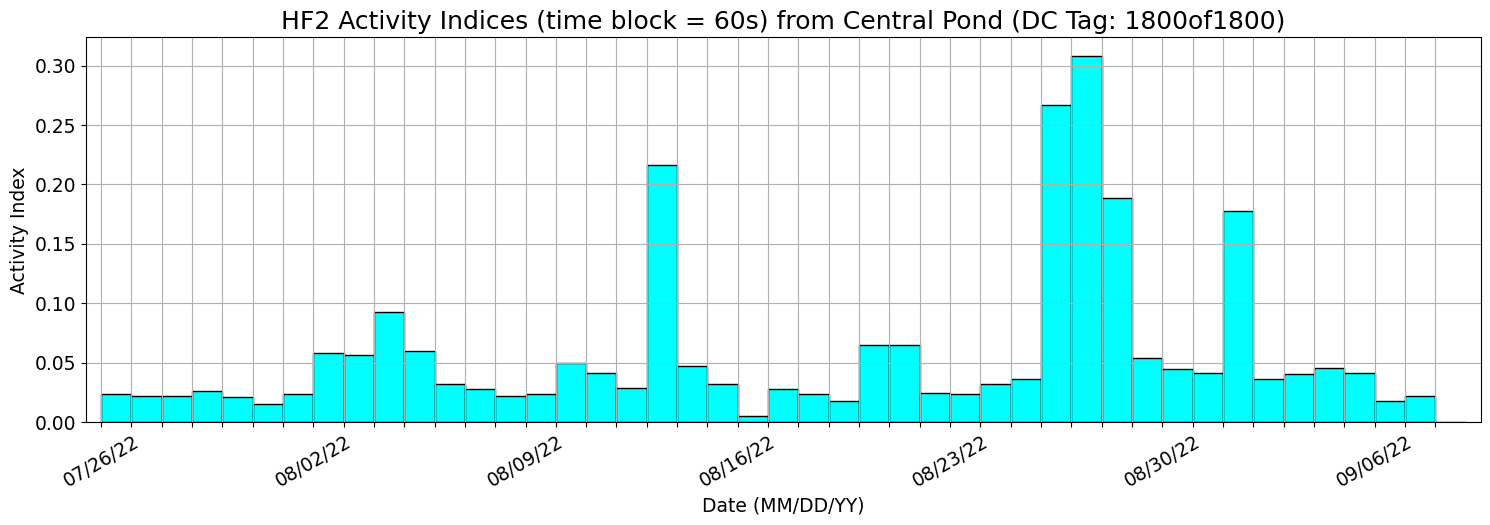

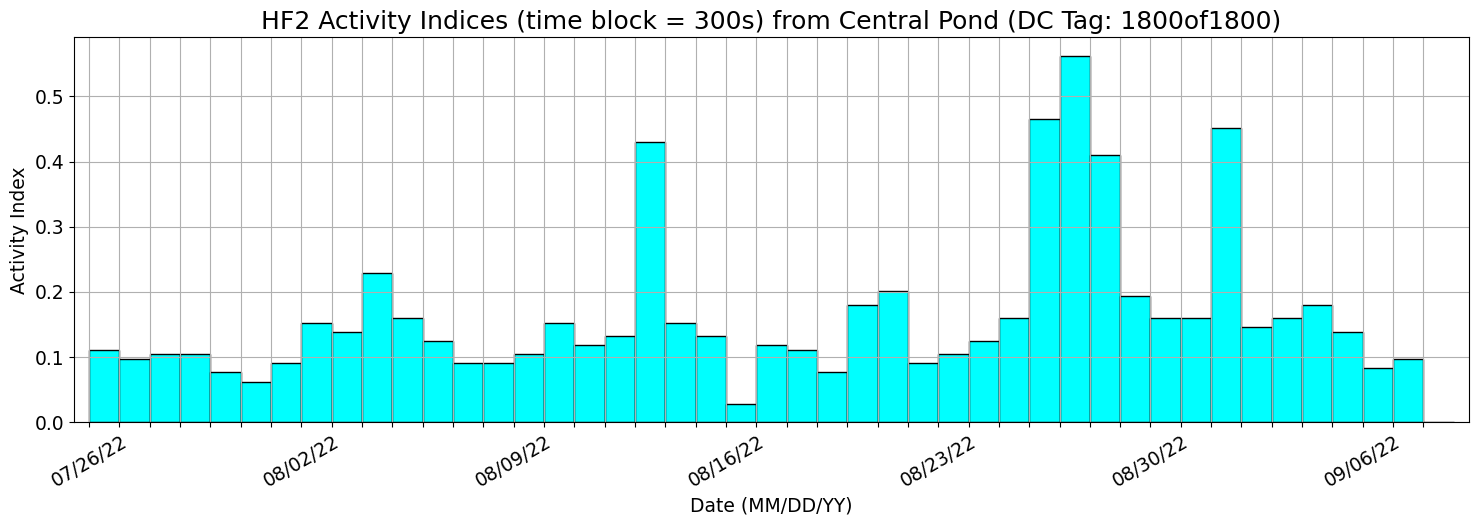

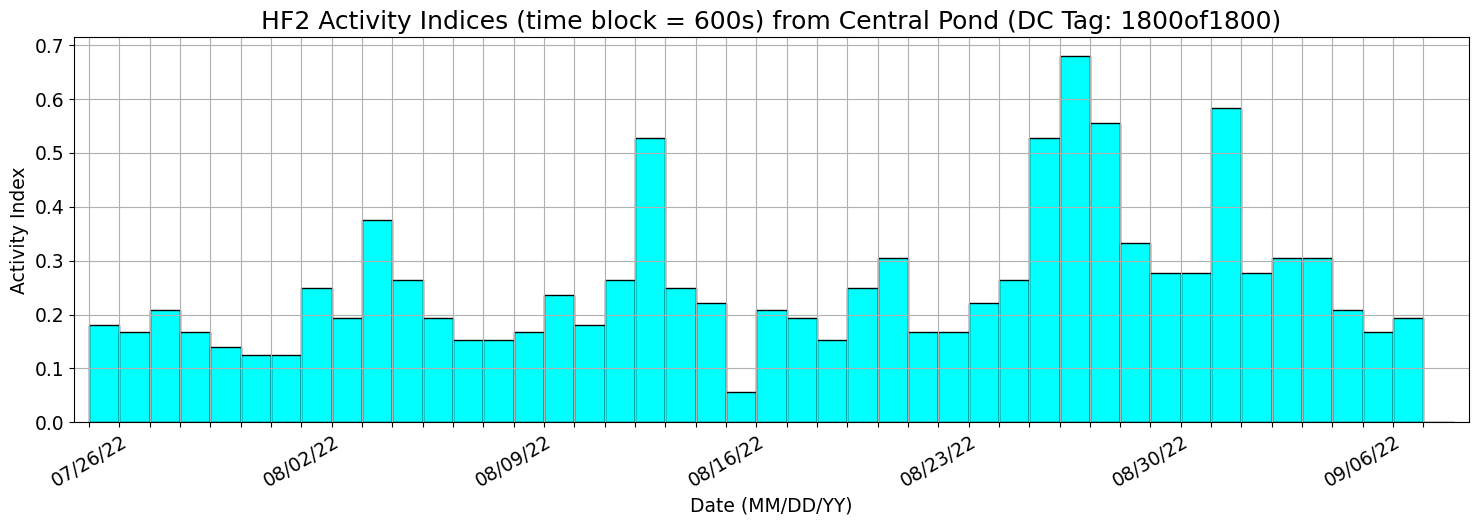

In [4]:
cycle_lengths = [1800, 360]
percent_ons = [0.1667]
specific_dc_tag = "1800of1800"

pipeline_params = dict()
pipeline_params['assemble_location_summary'] = False
pipeline_params["read_csv"] = False
pipeline_params["save_activity_grid"] = False
pipeline_params["save_presence_grid"] = False
pipeline_params["save_dc_night_comparisons"] = False
pipeline_params["save_activity_dc_comparisons"] = False
pipeline_params["save_presence_dc_comparisons"] = False
pipeline_params["show_plots"] = True
pipeline_params["show_PST"] = True

data_params = dict()
data_params["cycle_lengths"] = cycle_lengths
data_params["percent_ons"] = percent_ons
dc_tags = ss.get_list_of_dc_tags(data_params["cycle_lengths"], data_params["percent_ons"])
data_params["dc_tags"] = dc_tags
data_params["cur_dc_tag"] = specific_dc_tag
data_params['data_resolution_in_min'] = '30'
data_params['plotting_resolution_in_min'] = '720'

time_blocks = ['5', '60', '300', '600']

for site_key in FREQ_GROUPS.keys():
    for type_key in FREQ_GROUPS[site_key].keys():
        print(site_key, type_key)
        for time_block in time_blocks:
            data_params['index_time_block_in_secs'] = time_block
            data_params['recording_start'] = '02:00'
            data_params['recording_end'] = '14:00'
            data_params["site_name"] = SITE_NAMES[site_key]
            data_params["site_tag"] = site_key
            data_params["type_tag"] = type_key

            file_paths = get_file_paths(data_params)

            activity_inds_arr = pipeline.run_for_inds(data_params, pipeline_params, file_paths)
            activity_inds_arr.index = pd.DatetimeIndex(activity_inds_arr.index)
            activity_arr = activity_inds_arr.resample(f'720T').sum().between_time('0:00', '12:00', inclusive='left')
            dates = len(activity_arr.index)
            plt.rcParams.update({'font.size': (0.3*(dates))})
            plt.figure(figsize=(0.4*(dates), 5))
            time_block_duration = int(data_params['index_time_block_in_secs'])
            peak_index = (60*int(data_params['plotting_resolution_in_min'])/time_block_duration)
            title = f"{data_params['type_tag']} Activity Indices (time block = {time_block_duration}s) from {data_params['site_name']} (DC Tag: {data_params['cur_dc_tag']})"
            plt.title(title, fontsize=0.4*(dates))
            activity_df = dh.construct_activity_grid_for_inds(activity_arr, data_params["cur_dc_tag"])

            activity_dates = pd.DatetimeIndex(activity_df.columns).strftime("%m/%d/%y")
            plot_dates = [''] * len(activity_dates)
            plot_dates[::7] = activity_dates[::7]

            on = int(data_params['cur_dc_tag'].split('of')[0])
            total = int(data_params['cur_dc_tag'].split('of')[1])
            recover_ratio = total / on
            plt.bar(x=np.arange(0, len(activity_df.columns)), height=((recover_ratio*activity_df.values[0])/peak_index), 
                    width=1, edgecolor='k', facecolor=DC_COLOR_MAPPINGS[data_params['cur_dc_tag']])
            plt.xticks(np.arange(0, len(activity_df.columns))-0.5, plot_dates, rotation=30)
            plt.xlim(-1, len(activity_df.values[0]))
            plt.ylabel(f'Activity Index')
            plt.xlabel('Date (MM/DD/YY)')
            plt.grid(which='both')
            plt.show()